# Wind direction

In [1]:
import xarray as xr
import os
import sys
import glob
import numpy as np
import time
from xclim import sdba
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import circmean
import seaborn as sns

# Import utils
sys.path.append('/home/565/dh4185/mn51-dh4185/repos_collab/nesp_bff/')
import utils

# Static metadata dictionaries
from utils import locations, model_dict

# plotting niceties
plt.rcParams.update({"figure.figsize": (9, 5), "font.size": 12})
sns.set_style("whitegrid")

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/xclim/sdba.py:12: UserWarning: The `xclim.sdba` module has been split into its own package `xsdba`. Users are encouraged to use `xsdba` directly. For the time being, `xclim.sdba` will import `xsdba` to allow for API compatibility. This behaviour may change in the future. For more information, see: https://xsdba.readthedocs.io/en/stable/xclim_migration_guide.html
  warnings.warn(


In [2]:
##### Settings
_barra_v = "BARRA-R2" # C2

timezone_dict = {"Melbourne":"Melbourne", "Darwin":"Darwin", "Cairns":"Brisbane","Brisbane":"Brisbane",
                 "Longreach":"Brisbane","Mildura":"Melbourne","Adelaide":"Adelaide","Perth":"Perth",
                 "Sydney":"Sydney","Canberra":"Canberra","Hobart":"Hobart"}    
# Directories
root_dir = "/g/data/eg3/nesp_bff/"
plot_dir = "/g/data/eg3/nesp_bff/plots/qdc_adjustfactor/"

In [99]:
def diurnal_circular_mean(dir_deg, high=360, low=0):
    """
    Compute diurnal (hourly) circular mean wind direction.
    """
    return dir_deg.groupby("time.hour").reduce(
        circmean,
        dim="time",
        high=high,
        low=low,
        nan_policy="omit",
    )

def convert_to_local_time(da,loc):
    da_loc = da.sel(loc=loc)
    
    # Convert to pandas DatetimeIndex, localize UTC, convert to local, remove tz info
    da_time_local = pd.to_datetime(da_loc.time.values).tz_localize('UTC') \
                                          .tz_convert(f'Australia/{timezone_dict[loc]}') \
                                          .tz_localize(None)
    
    # Assign back to the DataArray
    da_loc_local = da_loc.assign_coords(time=da_time_local)
    return da_loc_local
    
def wind_dir_degree_from_vector(uas,vas):

    from xclim.indicators import convert
    wind_spd, wind_dir_degrees = convert.wind_speed_from_vector(uas=uas, vas=vas)
    return wind_dir_degrees.rename("windDir_degrees")


def degree_to_compassIndex(degrees, sfcWind, calm_threshold=0.026):
    """
    Convert wind direction in degrees (0–360) to 16-point compass index (1–16).
    Calm winds are assigned 0.
    """

    # Sector index: 1–16
    dir_index = (np.floor((degrees - 11.25) / 22.5) % 16) + 1

    # Mask calm winds
    dir_index = xr.where(sfcWind > calm_threshold, dir_index, 0)

    return dir_index.rename("windDir_index").astype(int)


# def dir16_to_deg(da):
#     """Convert wind direction in 16th (0-16) to degrees."""
#     # calm = 0 → NaN so it doesn’t pollute plots
#     da = da.where(da != 0)

#     # 1 → 22.5 (NNE), 2 → 45 (NE), ..., 16 → 360 (N)
#     return da * 22.5

def dir16_to_deg(x):
    """
    Convert wind direction in 16th (0–16) to degrees.

    - 0 (calm) → NaN
    - 1 → 22.5 (NNE), 2 → 45 (NE), ..., 16 → 360 (N)

    Works with:
    - xarray.DataArray
    - numpy.ndarray
    """
    # xarray objects have `.where`
    if hasattr(x, "where"):
        x = x.where(x != 0)
        return x * 22.5

    # numpy arrays / array-like
    x = np.asarray(x, dtype=float)
    x[x == 0] = np.nan
    return x * 22.5



def compute_max_frequency(da, sources, loc, n_dir_bins):
    bins = np.linspace(0, 2*np.pi, n_dir_bins + 1)
    max_freq = 0.0

    for src in sources:
        d = da.sel(source=src, loc=loc).values
        d = d[~np.isnan(d)]
        d = np.deg2rad(d)

        if len(d) == 0:
            continue

        h, _ = np.histogram(d, bins=bins)
        freq = h / h.sum()
        max_freq = max(max_freq, freq.max())

    return max_freq

def nice_tick_step(max_val):
    """
    Choose a nice radial tick step (fraction).
    """
    if max_val <= 0.25:
        return 0.05
    elif max_val <= 0.5:
        return 0.10
    else:
        return 0.20

def plot_windrose_overlay(
    da,
    model_source="barra-c2",
    obs_source="nathers",
    n_dir_bins=16,
    direction_type="degrees",  # "degrees" or "compass"
    ):
    """
    Plot wind-direction frequency wind roses for multiple locations,
    overlaying model vs observations.

    Parameters
    ----------
    da : xarray.DataArray
        Dimensions: source, loc, time
        Values: wind direction in degrees (0–360)

    model_source : str
        'barra-c2' or 'barra-r2'

    obs_source : str
        Typically 'nathers'

    n_dir_bins : int
        Number of directional bins (16 → 22.5° sectors)
    """

    n_locs = da.sizes["loc"]
    ncols = 3
    nrows = int(np.ceil(n_locs / ncols))

    # Direction bins (in radians)
    width = 2 * np.pi / n_dir_bins
    
    # Shift bins by half a bin so centers align with true directions (N, NE, ...)
    # bins = np.linspace(
    #     -width / 2,
    #     2 * np.pi - width / 2,
    #     n_dir_bins + 1
    # )
    
    # bin_centers = (bins[:-1] + bins[1:]) / 2
    # Direction bins (standard 0–2π)
    bins = np.linspace(0, 2*np.pi, n_dir_bins + 1)
    bin_centers = bins[:-1] + width / 2


    fig, axes = plt.subplots(
        nrows, ncols,
        subplot_kw=dict(polar=True),
        figsize=(10, 12),
        constrained_layout=True
    )

    axes = axes.flatten()

    for i,l in enumerate(da["loc"]):
        ax = axes[i]

        # --- dynamic radial scaling ---
        max_freq = compute_max_frequency(
            da,
            loc=l,
            sources=[model_source, obs_source],
            n_dir_bins=n_dir_bins
        )
    
        step = nice_tick_step(max_freq)
        r_max = np.ceil(max_freq / step) * step
        r_ticks = np.arange(step, r_max + step/2, step)
        r_tick_labels = [f"{int(r*100)}%" for r in r_ticks]

        # Extract data
        d_model = da.sel(source=model_source, loc=l).values
        d_obs   = da.sel(source=obs_source,   loc=l).values

        # Remove NaNs
        d_model = d_model[~np.isnan(d_model)]
        d_obs   = d_obs[~np.isnan(d_obs)]

        # # Convert to radians
        # d_model = np.deg2rad(d_model)
        # d_obs   = np.deg2rad(d_obs)
        
        # Normalise angles
        d_model = d_model % 360
        d_obs   = d_obs % 360
        
        # Shift by half a bin so centres align with N, NE, ...
        d_model = (d_model + np.rad2deg(width)/2) % 360
        d_obs   = (d_obs   + np.rad2deg(width)/2) % 360
    
        # Convert to radians
        if direction_type == "degrees":
            d_model = np.deg2rad(d_model)
            d_obs   = np.deg2rad(d_obs)
        
        elif direction_type == "compass":
            d_model = np.deg2rad(dir16_to_deg(d_model.astype(int)))
            d_obs   = np.deg2rad(dir16_to_deg(d_obs.astype(int)))
        
        else:
            raise ValueError("direction_type must be 'degrees' or 'compass'")

        # Histogram (normalized to frequency)
        h_model, _ = np.histogram(d_model, bins=bins)
        h_obs, _   = np.histogram(d_obs,   bins=bins)

        h_model = h_model / h_model.sum()
        h_obs   = h_obs / h_obs.sum()

        # Plot
        ax.bar(
            bin_centers,
            h_model,
            width=width,
            alpha=0.6,
            label=model_source
        )

        ax.bar(
            bin_centers,
            h_obs,
            width=width,
            alpha=0.6,
            label=obs_source
        )

        # Formatting
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        
        # Radial ticks and labels
        # Radial scale (dynamic)
        ax.set_ylim(0, r_max)
        ax.set_rticks(r_ticks)
        ax.set_yticklabels(r_tick_labels, fontsize=8)
        ax.set_rlabel_position(225)
     
        # Optional: move radial labels away from bars
        ax.set_rlabel_position(225)  # degrees

        # ax.set_yticklabels([])
        ax.set_title(l.values, fontsize=12, fontweight='bold')

        if i == 0:
            ax.legend(loc="lower right", bbox_to_anchor=(1.3, 1.1))

    # Hide unused subplots
    for j in range(n_locs, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(
        f"Wind Direction Frequency: {model_source} vs {obs_source}",
        fontsize=14
    )

    plt.show()

def print_nans(da,source):
    n = da.isnull().sum().item()
    print(f"  NaNs in {source}: {n}")
    
def copy_latlon(target, source):
    return target.assign_coords(
        lat=source.lat,
        lon=source.lon
    )

def plot_windrose_speed_overlay(
    da_dir,
    da_spd,
    model_dir_source="barra-r2-calibrated",
    model_spd_source="barra-r2-qdc",
    obs_source="nathers",
    n_dir_bins=16
):
    """
    Plot wind-speed wind roses for multiple locations,
    overlaying model vs observations.

    Radial axis shows mean wind speed (m/s) per directional sector.

    Parameters
    ----------
    da_dir : xarray.DataArray
        Wind direction [degrees], dims: source, loc, time

    da_spd : xarray.DataArray
        Wind speed [m/s], dims: source, loc, time

    model_source : str
        e.g. 'barra-r2'

    obs_source : str
        e.g. 'nathers'

    n_dir_bins : int
        Number of directional bins (16 → 22.5° sectors)
    """

    n_locs = da_dir.sizes["loc"]
    ncols = 3
    nrows = int(np.ceil(n_locs / ncols))

    # Direction bins (in radians)
    width = 2 * np.pi / n_dir_bins
    
    # Shift bins by half a bin so centers align with true directions (N, NE, ...)
    bins = np.linspace(
        -width / 2,
        2 * np.pi - width / 2,
        n_dir_bins + 1
    )
    bin_centers = (bins[:-1] + bins[1:]) / 2

    fig, axes = plt.subplots(
        nrows, ncols,
        subplot_kw=dict(polar=True),
        figsize=(10, 12),
        constrained_layout=True
    )

    axes = axes.flatten()

    for i, loc in enumerate(da_dir["loc"].values):
        ax = axes[i]

        # --- Extract data ---
        ddir_model = da_dir.sel(source=model_dir_source, loc=loc).values
        ddir_obs   = da_dir.sel(source=obs_source,   loc=loc).values

        spd_model  = da_spd.sel(source=model_spd_source, loc=loc).values
        spd_obs    = da_spd.sel(source=obs_source,   loc=loc).values

        # Remove NaNs consistently
        m_mask = ~np.isnan(ddir_model) & ~np.isnan(spd_model)
        o_mask = ~np.isnan(ddir_obs)   & ~np.isnan(spd_obs)

        ddir_model = np.deg2rad(ddir_model[m_mask])
        spd_model  = spd_model[m_mask]

        ddir_obs = np.deg2rad(ddir_obs[o_mask])
        spd_obs  = spd_obs[o_mask]

        # --- Sector-wise mean wind speed ---
        mean_spd_model = np.zeros(n_dir_bins)
        mean_spd_obs   = np.zeros(n_dir_bins)

        for j in range(n_dir_bins):
            msel = (ddir_model >= bins[j]) & (ddir_model < bins[j+1])
            osel = (ddir_obs   >= bins[j]) & (ddir_obs   < bins[j+1])

            mean_spd_model[j] = np.nanmean(spd_model[msel]) if msel.any() else np.nan
            mean_spd_obs[j]   = np.nanmean(spd_obs[osel])   if osel.any() else np.nan

        print(
            loc,
            "model valid sectors:",
            np.sum(~np.isnan(mean_spd_model)),
            "obs valid sectors:",
            np.sum(~np.isnan(mean_spd_obs))
        )

        if np.all(np.isnan(mean_spd_model)) and np.all(np.isnan(mean_spd_obs)):
            ax.set_visible(False)
            print(f"⚠ Skipping {loc}: no valid wind-speed data")
            continue

        # Dynamic radial scaling
        r_max = np.nanmax([mean_spd_model, mean_spd_obs])
        r_max = np.ceil(r_max)

        mean_spd_model_plot = np.nan_to_num(mean_spd_model, nan=0.0)
        mean_spd_obs_plot   = np.nan_to_num(mean_spd_obs,   nan=0.0)

        # --- Plot ---
        ax.bar(
            bin_centers,
            mean_spd_model_plot,
            width=width,
            alpha=0.6,
            label=model_dir_source
        )

        ax.bar(
            bin_centers,
            mean_spd_obs_plot,
            width=width,
            alpha=0.6,
            label=obs_source
        )

        # Formatting
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)

        ax.set_ylim(0, r_max)
        ax.set_rlabel_position(225)
        ax.set_title(loc, fontsize=12, fontweight="bold")

        if i == 0:
            ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.1))

    # Hide unused panels
    for j in range(n_locs, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle(
        f"Wind-Speed Wind Roses (Mean Speed per Sector)\n"
        f"{model_dir_source} vs {obs_source}",
        fontsize=14
    )

    plt.show()

def plot_bias(theta_bias_dict):
    import matplotlib.pyplot as plt
    import numpy as np
    from scipy.interpolate import CubicSpline
    
    # -------------------------------------------------------------------------
    # Configuration
    # -------------------------------------------------------------------------
    
    ncols = 3
    locs = list(theta_bias_dict.keys())
    nlocs = len(locs)
    nrows = int(np.ceil(nlocs / ncols))
    
    theta_fine = np.linspace(0, 2*np.pi, 361)
    
    # -------------------------------------------------------------------------
    # Create faceted polar plot
    # -------------------------------------------------------------------------
    
    fig, axes = plt.subplots(
        nrows=nrows,
        ncols=ncols,
        subplot_kw={"projection": "polar"},
        figsize=(4.2*ncols, 4.2*nrows),
        constrained_layout=True
    )
    
    axes = np.atleast_1d(axes).ravel()
    
    for ax, loc in zip(axes, locs):
    
        p = theta_bias_dict[loc]
    
        # Rebuild spline
        theta_knots = np.append(p["thetaj"], p["thetaj"][0] + 2*np.pi)
        bias_knots  = np.append(p["bias_knots"], p["bias_knots"][0])
    
        spline = CubicSpline(theta_knots, bias_knots, bc_type="periodic")
    
        bias_fine = spline(theta_fine)
    
        # Plot smooth bias curve
        ax.plot(
            theta_fine,
            np.rad2deg(bias_fine),
            lw=2
        )
    
        # Plot knots
        ax.scatter(
            p["thetaj"],
            np.rad2deg(p["bias_knots"]),
            s=25,
            zorder=3
        )
    
        # Formatting
        ax.set_title(loc,  fontsize=12, fontweight='bold', pad=10)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        ax.set_thetagrids(np.arange(0, 360, 45))
    
        ax.set_rlabel_position(225)
        ax.grid(alpha=0.4)
    
    # -------------------------------------------------------------------------
    # Remove unused subplots
    # -------------------------------------------------------------------------
    
    for ax in axes[len(locs):]:
        ax.remove()
    
    # -------------------------------------------------------------------------
    # Global labels
    # -------------------------------------------------------------------------
    
    fig.suptitle(
        "Direction-dependent wind direction bias\n(sector-based circular spline)",
        fontsize=14,
        y=1.02
    )
    
    plt.show()


In [4]:
# --- test --- 
index = xr.DataArray((16 * np.random.rand(20)).astype(int),#[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16],
                     dims="time")
degrees = xr.DataArray(np.round(360 * np.random.rand(20),1),#[0, 22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5, 180. , 202.5, 225. , 247.5, 270. , 292.5, 315. , 337.5, 360. ],
                       dims="time")
compass = {0:"calm",1:"NNE",2:"NE",3:"ENE",4:"E",5:"ESE",6:"SE",7:"SSE",8:"S",9:"SSW",10:"SW",11:"WSW",12:"W",13:"WNW",14:"NW",15:"NNW",16:"N"}

sfcWind = xr.DataArray(np.random.rand(20), #[5.0,5.0, 5.0, 0.0, 3.0, 5.0, 3.0, 5.0, 3.0, 5.0, 3.0, 5.0, 3.0, 5.0, 3.0, 5.0,2.0],
                       dims="time")
for i in range(len(index)-1):
    print(f"Degrees ({degrees.values[i]}) to compass index: {degree_to_compassIndex(degrees[i], sfcWind[i]).values} -> {compass[int(degree_to_compassIndex(degrees[i], sfcWind[i]).values)]}")
    print(f"Compass index ({index[i].values}) to degrees: {dir16_to_deg(index[i]).values}")


Degrees (219.8) to compass index: 10 -> SW
Compass index (13) to degrees: 292.5
Degrees (329.5) to compass index: 15 -> NNW
Compass index (9) to degrees: 202.5
Degrees (207.5) to compass index: 9 -> SSW
Compass index (3) to degrees: 67.5
Degrees (56.4) to compass index: 3 -> ENE
Compass index (4) to degrees: 90.0
Degrees (169.1) to compass index: 8 -> S
Compass index (0) to degrees: nan
Degrees (61.2) to compass index: 3 -> ENE
Compass index (8) to degrees: 180.0
Degrees (54.9) to compass index: 2 -> NE
Compass index (11) to degrees: 247.5
Degrees (316.5) to compass index: 14 -> NW
Compass index (13) to degrees: 292.5
Degrees (270.9) to compass index: 12 -> W
Compass index (8) to degrees: 180.0
Degrees (15.4) to compass index: 1 -> NNE
Compass index (12) to degrees: 270.0
Degrees (87.3) to compass index: 4 -> E
Compass index (12) to degrees: 270.0
Degrees (262.5) to compass index: 12 -> W
Compass index (12) to degrees: 270.0
Degrees (274.7) to compass index: 12 -> W
Compass index (15) 

In [5]:
# --- Read extracted wind data and concatenate across sources ---
loc_list_barra_r2_winddeg=[]
loc_list_barra_r2_sfcW=[]
loc_list_barra_qdc_sfcW=[]
loc_list_barra_r2_windD=[]
loc_list_barra_c2_winddeg=[]
loc_list_barra_c2_sfcW=[]
loc_list_barra_c2_windD=[]
loc_list_nathers_windD=[]
loc_list_nathers_sfcW=[]

for loc in timezone_dict:
    print(loc)
    # Open files
    temp_barra_r2 = xr.open_dataset(f"{root_dir}step1_raw_data_extraction/BARRA-R2/{loc}_AUS-11_ERA5_historical_hres_BOM_BARRA-R2_v1_1hr_1985-2024.nc").load()
    temp_barra_c2 = xr.open_dataset(f"{root_dir}step1_raw_data_extraction/BARRA-C2/{loc}_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_1hr_1985-2024.nc").load()
    temp_nathers = xr.open_dataset(glob.glob(f"{root_dir}/NatHERS/raw_data/{loc}_*_NatHERS_1990-2015.nc")[0]).load()
    # QDC adjusted BARRA needs to be shifted back in time as the QDC methods converted to local time
    temp_barra_qdc = xr.open_dataset(f"{root_dir}step2_qdc_scaling/{_barra_v}/{loc}_AUS-11_ERA5_historical_hres_BOM_{_barra_v}_v1_1hr_1990-2014_QDC-NatHERS.nc").load() 
    offset_hours = int(temp_barra_qdc.time_offset.item())
    temp_barra_qdc = temp_barra_qdc.assign_coords(
        time=temp_barra_qdc.time - np.timedelta64(offset_hours, "h")
    )

    # Check NaNs and lat/lon
    print(f"BARRA-C2: lat = {temp_barra_c2.lat.item()}, lon = {temp_barra_c2.lon.item()}")
    print_nans(temp_barra_c2.sfcWind,'barra-c2')
    print(f"BARRA-R2: lat = {temp_barra_r2.lat.item()}, lon = {temp_barra_r2.lon.item()}")
    print_nans(temp_barra_r2.sfcWind,'barra-r2')
    print(f"{_barra_v}: lat = {temp_barra_qdc.lat.item()}, lon = {temp_barra_qdc.lon.item()}")
    print_nans(temp_barra_qdc.sfcWind,f"{_barra_v.lower()} qdc")
    print(f"NatHERS: lat = {temp_nathers.lat.item()}, lon = {temp_nathers.lon.item()}")
    print_nans(temp_nathers.sfcWind,'nathers')
    
    # Align time series
    temp_barra_c2, temp_barra_r2, temp_barra_qdc, temp_nathers = xr.align(
        temp_barra_c2,
        temp_barra_r2,
        temp_barra_qdc,
        temp_nathers,
        join="inner"
    )
    
    # BARRA-R2
    loc_list_barra_r2_sfcW.append(temp_barra_r2.sfcWind)
    loc_list_barra_r2_winddeg.append(wind_dir_degree_from_vector(temp_barra_r2.uas, temp_barra_r2.vas))
    loc_list_barra_r2_windD.append(degree_to_compassIndex(wind_dir_degree_from_vector(temp_barra_r2.uas,
                                                                                   temp_barra_r2.vas),temp_barra_r2.sfcWind))
    # BARRA-C2
    loc_list_barra_c2_sfcW.append(temp_barra_c2.sfcWind)
    loc_list_barra_c2_winddeg.append(wind_dir_degree_from_vector(temp_barra_c2.uas, temp_barra_c2.vas))
    loc_list_barra_c2_windD.append(degree_to_compassIndex(wind_dir_degree_from_vector(temp_barra_c2.uas,
                                                                                   temp_barra_c2.vas),temp_barra_c2.sfcWind))
    # BARRA QDC
    loc_list_barra_qdc_sfcW.append(temp_barra_qdc.sfcWind)

    # Nathers
    loc_list_nathers_windD.append(temp_nathers.wind_dir)
    loc_list_nathers_sfcW.append(temp_nathers.sfcWind)

barra_r2_sfcW = xr.concat(loc_list_barra_r2_sfcW, pd.Index(list(timezone_dict.keys()),name="loc"))
barra_r2_windD = xr.concat(loc_list_barra_r2_windD, pd.Index(list(timezone_dict.keys()),name="loc"))
barra_r2_winddeg = xr.concat(loc_list_barra_r2_winddeg, pd.Index(list(timezone_dict.keys()),name="loc"))

barra_c2_sfcW = xr.concat(loc_list_barra_c2_sfcW, pd.Index(list(timezone_dict.keys()),name="loc"))
barra_c2_windD = xr.concat(loc_list_barra_c2_windD, pd.Index(list(timezone_dict.keys()),name="loc"))
barra_c2_winddeg = xr.concat(loc_list_barra_c2_winddeg, pd.Index(list(timezone_dict.keys()),name="loc"))

barra_qdc_sfcW = xr.concat(loc_list_barra_qdc_sfcW, pd.Index(list(timezone_dict.keys()),name="loc"))

nathers_sfcW = xr.concat(loc_list_nathers_sfcW, pd.Index(list(timezone_dict.keys()),name="loc"))
nathers_windD = xr.concat(loc_list_nathers_windD, pd.Index(list(timezone_dict.keys()),name="loc"))

# copy lat/lon
barra_r2_sfcW   = copy_latlon(barra_r2_sfcW,   nathers_sfcW)
barra_c2_sfcW   = copy_latlon(barra_c2_sfcW,   nathers_sfcW)
barra_qdc_sfcW = copy_latlon(barra_qdc_sfcW,   nathers_sfcW)

barra_r2_windD  = copy_latlon(barra_r2_windD,  nathers_windD)
barra_c2_windD  = copy_latlon(barra_c2_windD,  nathers_windD)

barra_r2_winddeg = copy_latlon(barra_r2_winddeg, nathers_windD)
barra_c2_winddeg = copy_latlon(barra_c2_winddeg, nathers_windD)

# Wind speed array
barra_r2_sfcW_p = barra_r2_sfcW.expand_dims(source=["barra-r2"])
barra_c2_sfcW_p = barra_c2_sfcW.expand_dims(source=["barra-c2"])
barra_qdc_sfcW_p = barra_qdc_sfcW.expand_dims(source=[f"{_barra_v.lower()}-qdc"])
nathers_sfcW_p = nathers_sfcW.expand_dims(source=["nathers"])
all_wind_spd = xr.concat([barra_r2_sfcW_p, barra_c2_sfcW_p, barra_qdc_sfcW_p, nathers_sfcW_p], dim="source",coords="minimal")

# Wind direction
# Convert to degree
barra_r2_deg = barra_r2_winddeg.expand_dims(source=["barra-r2"]).rename("wind_degrees") #dir16_to_deg(barra_r2_windD) .rename("windDir_from_index")
barra_c2_deg = barra_c2_winddeg.expand_dims(source=["barra-c2"]).rename("wind_degrees")  #dir16_to_deg(barra_c2_windD) .rename("windDir_from_index")
nathers_deg = dir16_to_deg(nathers_windD).expand_dims(source=["nathers"]).rename("windDir_from_index")

all_wind_dir_deg = xr.concat([barra_r2_deg, barra_c2_deg, nathers_deg], dim="source",coords="minimal")
all_wind_dir_index = xr.concat([barra_r2_windD.expand_dims(source=["barra-r2"]),
                          barra_c2_windD.expand_dims(source=["barra-c2"]),
                          nathers_windD.expand_dims(source=["nathers"])], dim="source",coords='minimal')


Melbourne
BARRA-C2: lat = -37.65, lon = 144.82
  NaNs in barra-c2: 0
BARRA-R2: lat = -37.62, lon = 144.8
  NaNs in barra-r2: 0
BARRA-R2: lat = -37.62, lon = 144.8
  NaNs in barra-r2 qdc: 0
NatHERS: lat = -37.666, lon = 144.832
  NaNs in nathers: 3860
Darwin
BARRA-C2: lat = -12.41, lon = 130.9
  NaNs in barra-c2: 0
BARRA-R2: lat = -12.43, lon = 130.94
  NaNs in barra-r2: 0
BARRA-R2: lat = -12.43, lon = 130.94
  NaNs in barra-r2 qdc: 0
NatHERS: lat = -12.424, lon = 130.893
  NaNs in nathers: 1484
Cairns
BARRA-C2: lat = -16.89, lon = 145.74
  NaNs in barra-c2: 0
BARRA-R2: lat = -16.83, lon = 145.68
  NaNs in barra-r2: 0
BARRA-R2: lat = -16.83, lon = 145.68
  NaNs in barra-r2 qdc: 0
NatHERS: lat = -16.874, lon = 145.746
  NaNs in nathers: 7628
Brisbane
BARRA-C2: lat = -27.41, lon = 153.1
  NaNs in barra-c2: 0
BARRA-R2: lat = -27.39, lon = 153.05
  NaNs in barra-r2: 0
BARRA-R2: lat = -27.5, lon = 153.05
  NaNs in barra-r2 qdc: 0
NatHERS: lat = -27.392, lon = 153.129
  NaNs in nathers: 53674

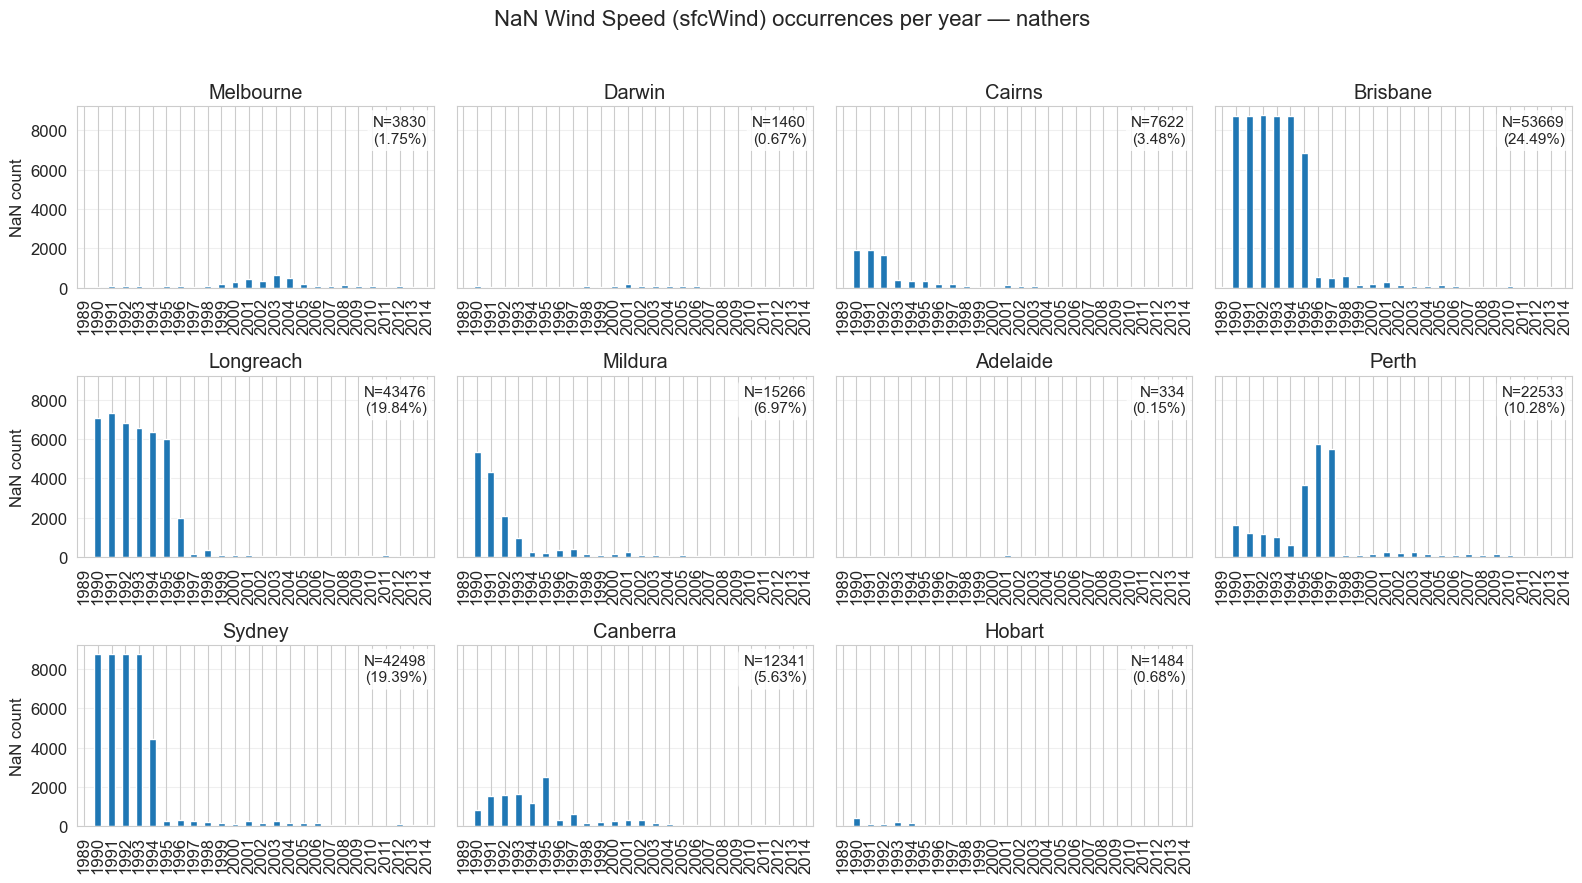

In [6]:
d = all_wind_spd
src = "nathers"   # change or loop over sources

nan_per_year_by_loc = {}
nan_stats_by_loc = {}

# --- collect stats ---
for loc in d["loc"].values:
    ws = d.sel(source=src, loc=loc)

    nan_per_year = ws.isnull().groupby("time.year").sum()
    nan_per_year_by_loc[loc] = nan_per_year.to_series()

    n_nan = ws.isnull().sum().item()
    n_total = ws.size
    pct_nan = 100 * n_nan / n_total

    nan_stats_by_loc[loc] = (n_nan, pct_nan)

# --- plotting ---
n_locs = len(nan_per_year_by_loc)
ncols = 4
nrows = int(np.ceil(n_locs / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharey=True
)

axes = axes.flatten()

for ax, loc in zip(axes, nan_per_year_by_loc.keys()):
    series = nan_per_year_by_loc[loc]
    series.plot.bar(ax=ax)

    n_nan, pct_nan = nan_stats_by_loc[loc]

    ax.set_title(str(loc))
    ax.set_xlabel("")
    ax.set_ylabel("NaN count")
    ax.grid(axis="y", alpha=0.3)

    # --- annotation in top-right corner ---
    ax.text(
        0.98, 0.95,
        f"N={n_nan}\n({pct_nan:.2f}%)",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=11,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

# Hide unused axes
for ax in axes[len(nan_per_year_by_loc):]:
    ax.set_visible(False)

fig.suptitle(f"NaN Wind Speed (sfcWind) occurrences per year — {src}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

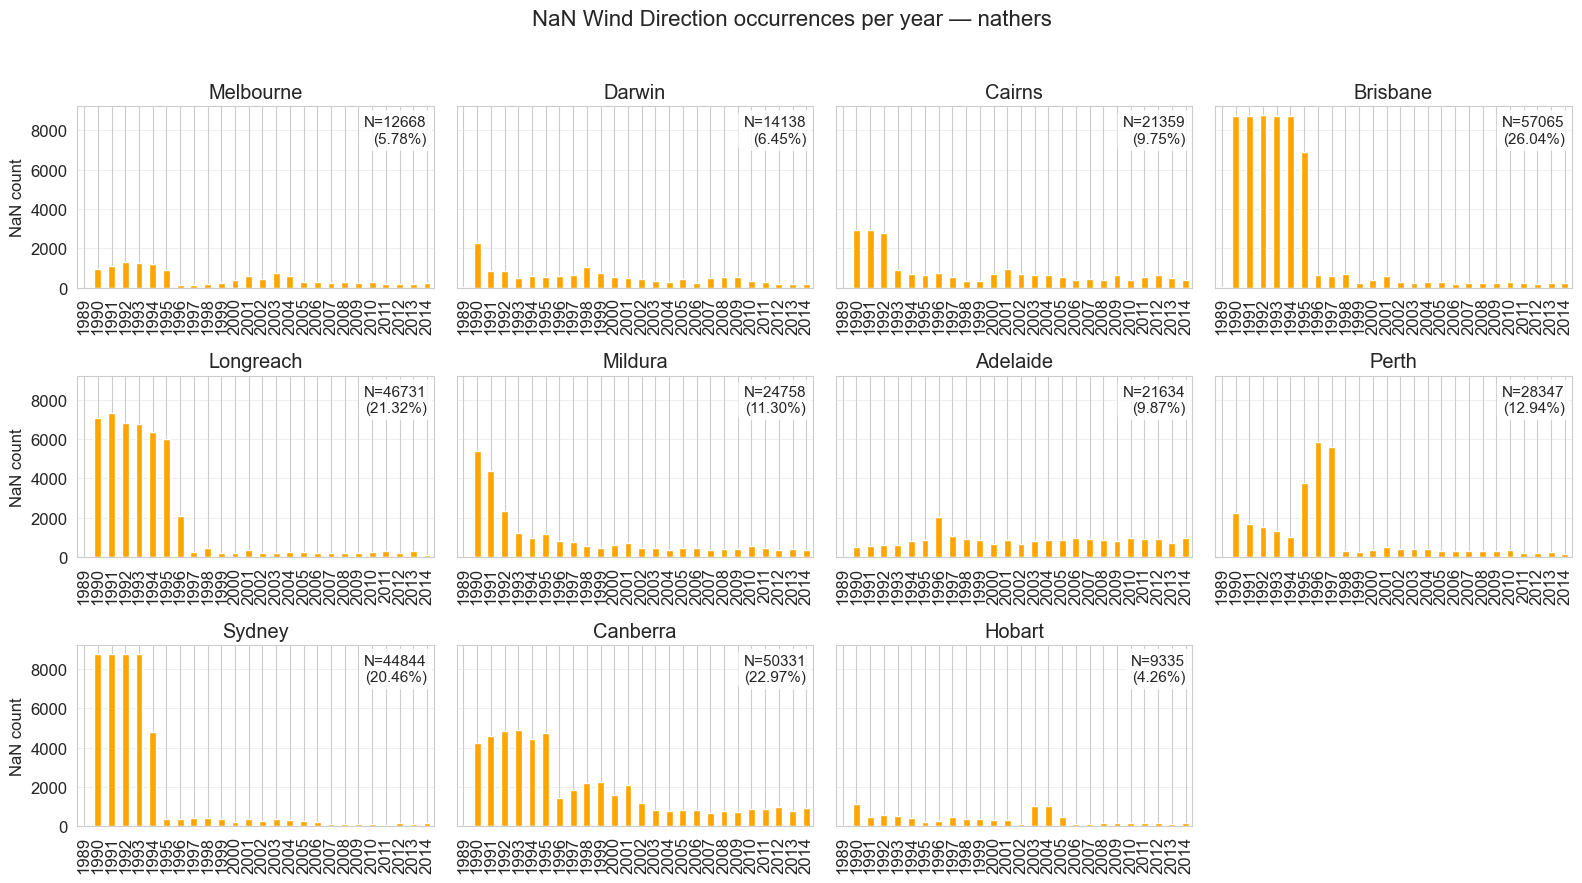

In [7]:
d = all_wind_dir_deg
src = "nathers"   # change or loop over sources

nan_per_year_by_loc = {}
nan_stats_by_loc = {}

# --- collect stats ---
for loc in d["loc"].values:
    ws = d.sel(source=src, loc=loc)

    nan_per_year = ws.isnull().groupby("time.year").sum()
    nan_per_year_by_loc[loc] = nan_per_year.to_series()

    n_nan = ws.isnull().sum().item()
    n_total = ws.size
    pct_nan = 100 * n_nan / n_total

    nan_stats_by_loc[loc] = (n_nan, pct_nan)

# --- plotting ---
n_locs = len(nan_per_year_by_loc)
ncols = 4
nrows = int(np.ceil(n_locs / ncols))

fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(4 * ncols, 3 * nrows),
    sharey=True
)

axes = axes.flatten()

for ax, loc in zip(axes, nan_per_year_by_loc.keys()):
    series = nan_per_year_by_loc[loc]
    series.plot.bar(ax=ax,color="orange")

    n_nan, pct_nan = nan_stats_by_loc[loc]

    ax.set_title(str(loc))
    ax.set_xlabel("")
    ax.set_ylabel("NaN count")
    ax.grid(axis="y", alpha=0.3)

    # --- annotation in top-right corner ---
    ax.text(
        0.98, 0.95,
        f"N={n_nan}\n({pct_nan:.2f}%)",
        transform=ax.transAxes,
        ha="right",
        va="top",
        fontsize=11,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

# Hide unused axes
for ax in axes[len(nan_per_year_by_loc):]:
    ax.set_visible(False)

fig.suptitle(f"NaN Wind Direction occurrences per year — {src}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Wind speed

In [8]:
# --- Filter for calm winds (wind dir index == 0)
for l in nathers_sfcW["loc"]:
    calm_ws = nathers_sfcW.sel(loc=l.values).where(nathers_windD.sel(loc=l.values)== 0).dropna(dim="time")
    print(f"max wind spd for {l.values}: {calm_ws.max().item()}, Length: {len(calm_ws)}")

# 6.7ms-1 for Hobart is too much for calm conditions, where the other locations have 0.0.

max wind spd for Melbourne: 0.0, Length: 8834
max wind spd for Darwin: 0.0, Length: 12662
max wind spd for Cairns: 0.0, Length: 13728
max wind spd for Brisbane: 0.0, Length: 3390
max wind spd for Longreach: 0.0, Length: 3017
max wind spd for Mildura: 0.0, Length: 9481
max wind spd for Adelaide: 0.0, Length: 21299
max wind spd for Perth: 0.0, Length: 5807
max wind spd for Sydney: 0.0, Length: 2345
max wind spd for Canberra: 0.0, Length: 37901
max wind spd for Hobart: 6.7, Length: 7850


In [9]:
# Filter for calm winds (wind dir index == 0)
for l in barra_r2_sfcW["loc"]:
    calm_ws = barra_r2_sfcW.sel(loc=l.values).where(barra_r2_windD.sel(loc=l.values)== 0).dropna(dim="time")
    print(f"max wind spd for {l.values}: {calm_ws.max().item() if len(calm_ws)!=0 else 0.0}, Length: {len(calm_ws)}")

# very few to none calm days in BARRA

max wind spd for Melbourne: 0.0, Length: 4
max wind spd for Darwin: 0.0, Length: 3
max wind spd for Cairns: 0.0, Length: 4
max wind spd for Brisbane: 0.0, Length: 1
max wind spd for Longreach: 0.0, Length: 0
max wind spd for Mildura: 0.0, Length: 1
max wind spd for Adelaide: 0.0, Length: 4
max wind spd for Perth: 0.0, Length: 0
max wind spd for Sydney: 0.0, Length: 1
max wind spd for Canberra: 0.0, Length: 9
max wind spd for Hobart: 0.0, Length: 11


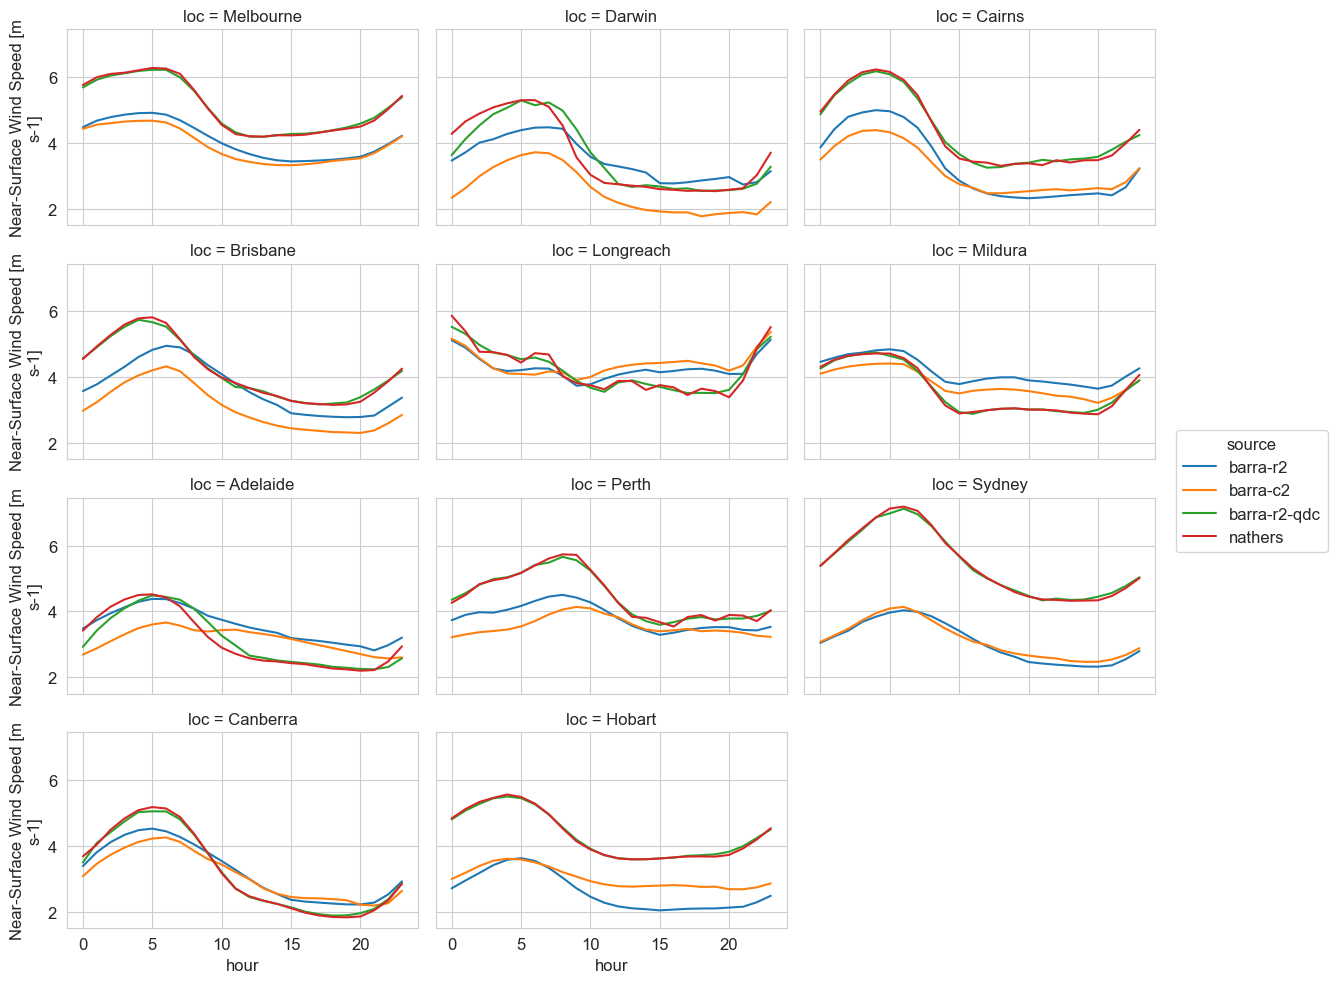

In [10]:
all_wind_spd_p = all_wind_spd.groupby("time.hour").mean("time")
all_wind_spd_p.plot(
    hue="source",
    col="loc",
    col_wrap=3,
    figsize=(12,10)
)

### Wind direction

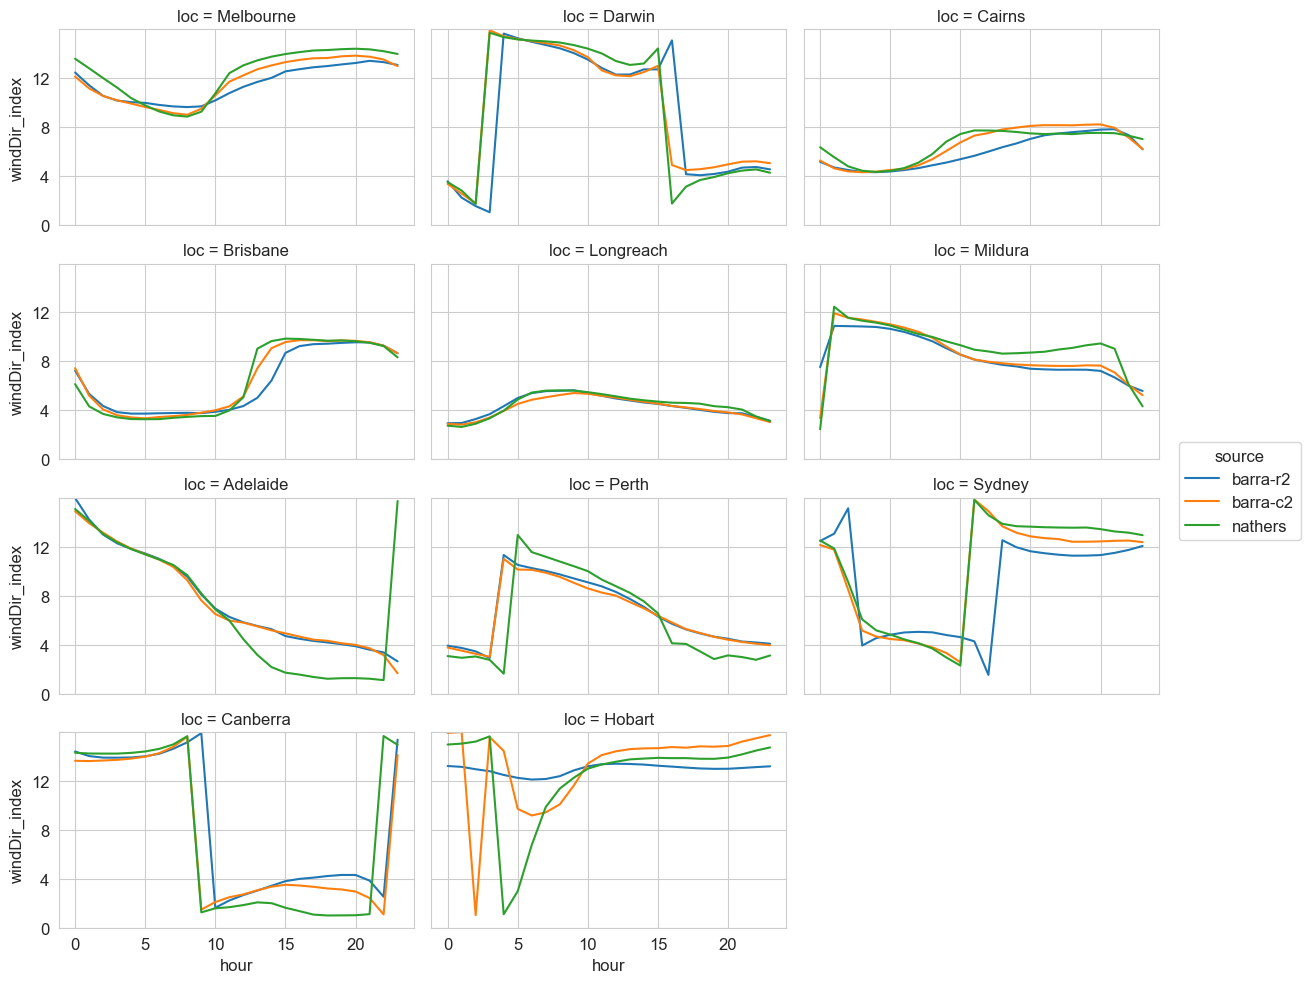

In [11]:
g = diurnal_circular_mean(all_wind_dir_index,high=16,low=1).plot(    #.groupby("time.hour").mean("time").plot(
    hue="source",
    col="loc",
    col_wrap=3,
    figsize=(12,10),
    ylim=(1, 16)
)

# Set y-ticks on every axis
for ax in g.axes.flat:
    ax.set_yticks(np.arange(0, 16, 4)
)


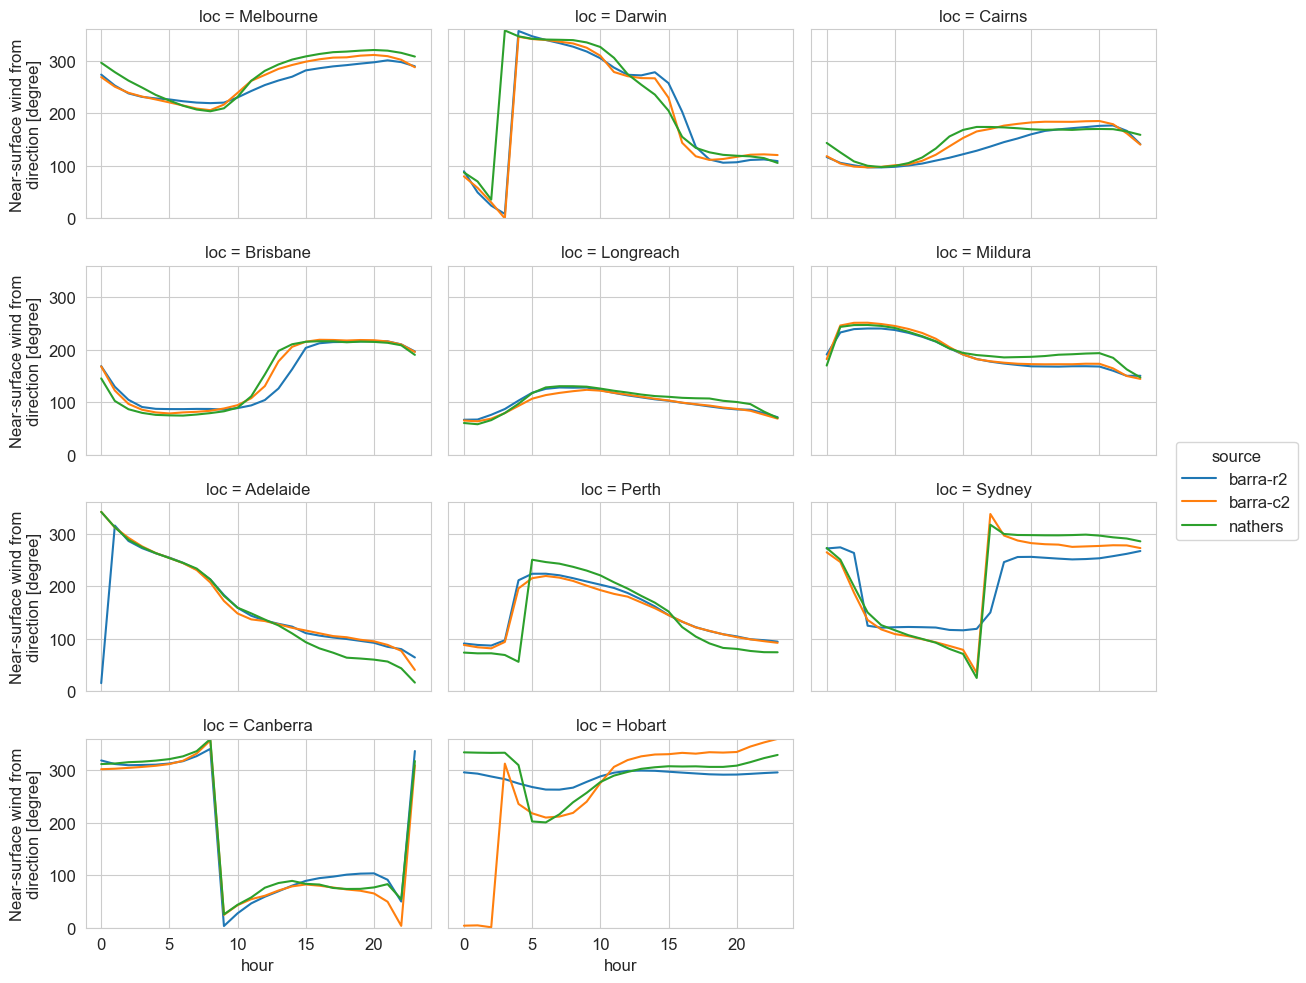

In [12]:
diurnal_circular_mean(all_wind_dir_deg).plot(   #all_wind_dir_deg.groupby("time.hour").mean("time").plot(
    hue="source",
    col="loc",
    col_wrap=3,
    figsize=(12,10),
    ylim=(0, 360)
)

# Set y-ticks on every axis
for ax in g.axes.flat:
    ax.set_yticks(np.arange(0, 361, 45))

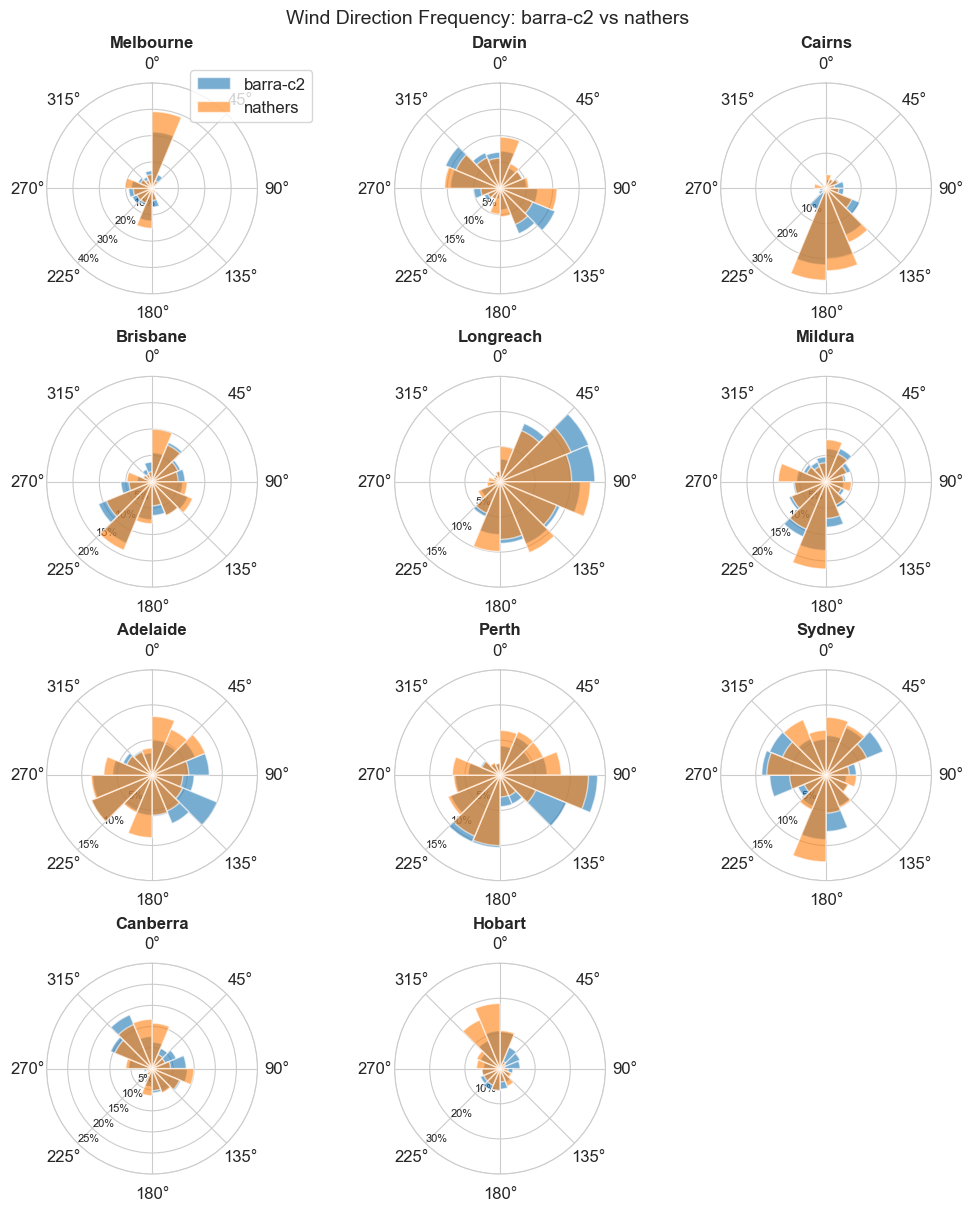

In [13]:
plot_windrose_overlay(
    da=all_wind_dir_deg,
    model_source="barra-c2",
    obs_source="nathers",
    n_dir_bins=16
)

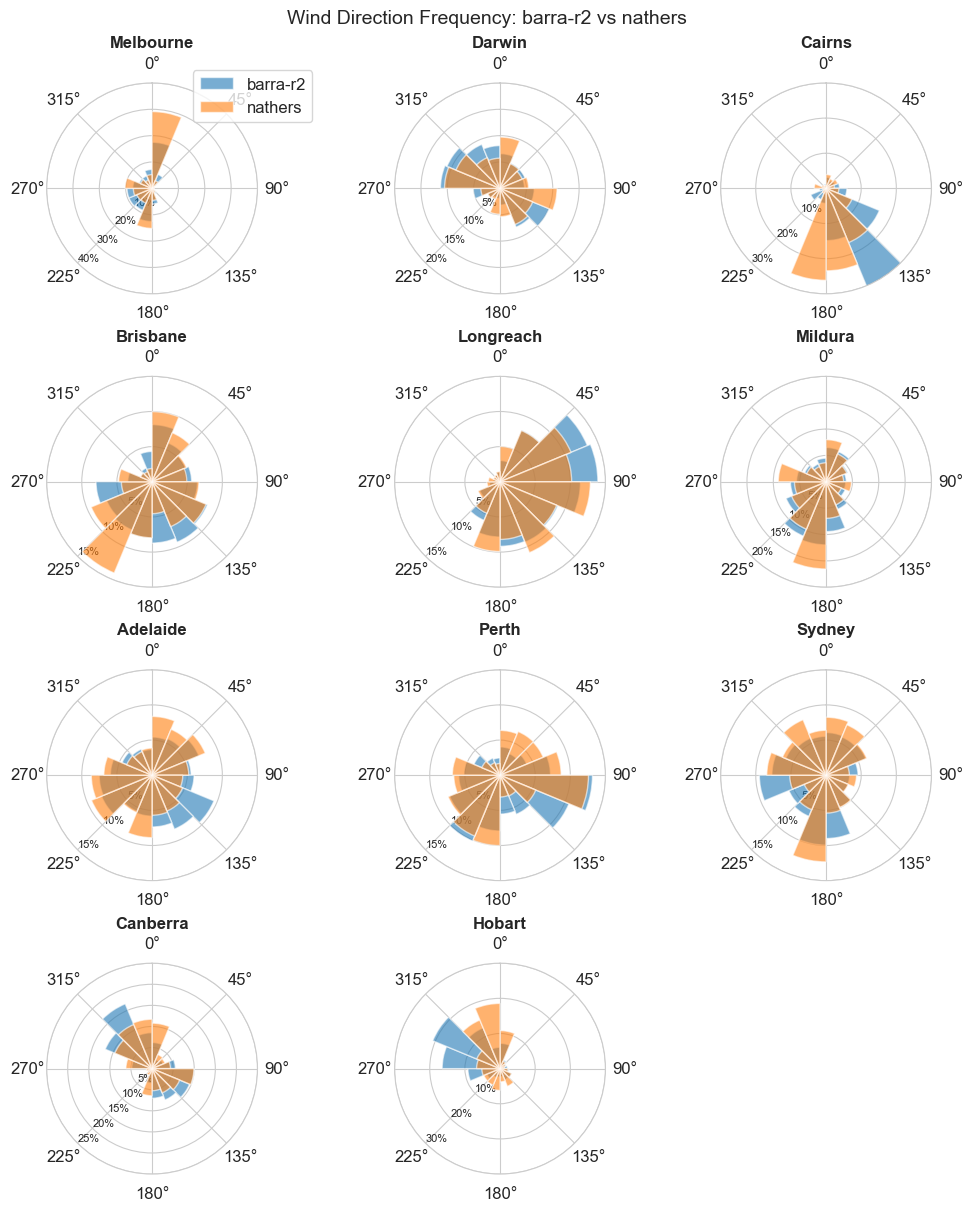

In [14]:
plot_windrose_overlay(
    da=all_wind_dir_deg,
    model_source="barra-r2",
    obs_source="nathers",
    n_dir_bins=16
)

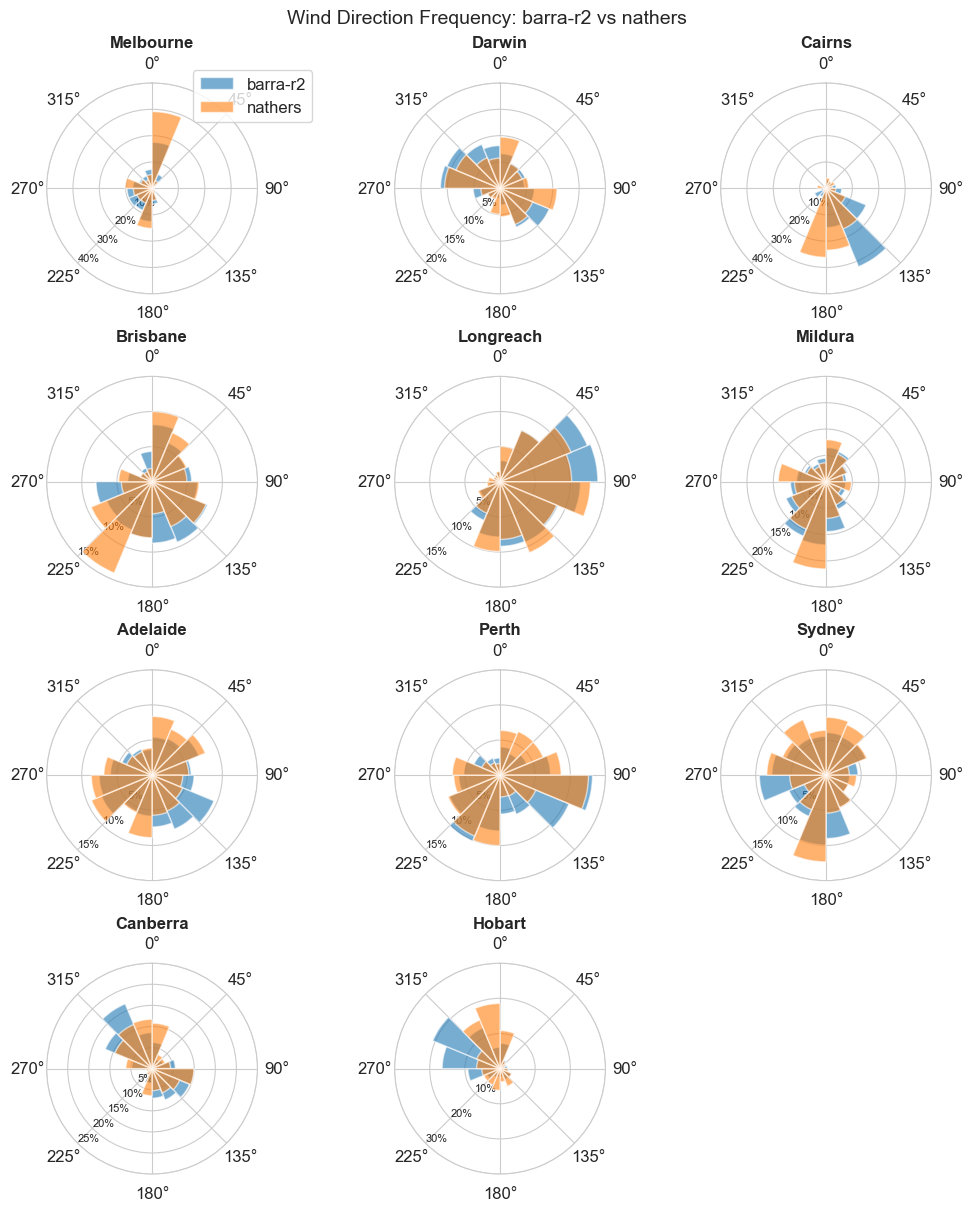

In [16]:
plot_windrose_overlay(
    da=dir16_to_deg(all_wind_dir_index),
    model_source="barra-r2",
    obs_source="nathers",
    n_dir_bins=16,
    direction_type="degrees"
)

## Bias adjustment

In [68]:
d = all_wind_dir_deg
for src in d.source.values:
    print(f"\n Nans in {src}")
    for loc in d["loc"].values:
        n = d.sel(source=src, loc=loc).isnull().sum().item()
        print(f"   {loc}: {n}")



 Nans in barra-r2
   Melbourne: 2
   Darwin: 2
   Cairns: 2
   Brisbane: 2
   Longreach: 2
   Mildura: 2
   Adelaide: 2
   Perth: 2
   Sydney: 2
   Canberra: 2
   Hobart: 2

 Nans in barra-c2
   Melbourne: 2
   Darwin: 2
   Cairns: 2
   Brisbane: 2
   Longreach: 2
   Mildura: 2
   Adelaide: 2
   Perth: 2
   Sydney: 2
   Canberra: 2
   Hobart: 2

 Nans in nathers
   Melbourne: 12668
   Darwin: 14138
   Cairns: 21359
   Brisbane: 57065
   Longreach: 46731
   Mildura: 24758
   Adelaide: 21634
   Perth: 28347
   Sydney: 44844
   Canberra: 50331
   Hobart: 9335


===========================================================================================================

In [74]:
sector_indices

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### WITH binning of BARRA wind direction
(i.e. same 1-16 index degree equivalents (22.5, 45, 67.5, etc) as Nathers)

In [118]:
# =============================================================================
# Direction-dependent wind direction calibration
# =============================================================================

import numpy as np
import xarray as xr
from scipy.interpolate import CubicSpline

# -----------------------------------------------------------------------------
# Helper functions
# -----------------------------------------------------------------------------

def to_radians(deg):
    return np.deg2rad(deg)


def to_degrees(rad):
    return np.rad2deg(rad)


def wrap_degrees(deg):
    return (deg + 360) % 360


def circular_difference(obs_deg, mod_deg):
    """
    Smallest signed angular difference (obs - mod), degrees
    """
    diff = obs_deg - mod_deg
    return (diff + 180) % 360 - 180


# -----------------------------------------------------------------------------
# Configuration
# -----------------------------------------------------------------------------

calm_threshold = 0.026
n_sectors = 16
sector_size_deg = 22.5
min_samples = 1000

# -----------------------------------------------------------------------------
# Storage
# -----------------------------------------------------------------------------

adjusted_dir_by_loc_idx = {}
params_by_loc_idx = {}

# -----------------------------------------------------------------------------
# Loop over locations
# -----------------------------------------------------------------------------

for loc in all_wind_spd["loc"].values:
    print("\n" + "=" * 90)
    print(f"Processing location: {loc}")
    print("=" * 90)

    # -------------------------------------------------------------------------
    # 1. Extract data
    # -------------------------------------------------------------------------

    speed_obs = all_wind_spd.sel(source="nathers", loc=loc)
    dir_obs_idx = all_wind_dir_index.sel(source="nathers", loc=loc)

    speed_mod = all_wind_spd.sel(source="barra-r2", loc=loc)
    speed_mod_adj = all_wind_spd.sel(source="barra-r2-qdc", loc=loc)

    dir_mod_idx = degree_to_compassIndex(
        all_wind_dir_deg.sel(source="barra-r2", loc=loc),
        speed_mod
    )

    # -------------------------------------------------------------------------
    # 2. Filter calm winds
    # -------------------------------------------------------------------------

    valid = (
        (speed_obs > calm_threshold) &
        (speed_mod_adj > calm_threshold) &
        (dir_obs_idx > 0) &
        (dir_mod_idx > 0)
    )

    dir_obs_idx_v = dir_obs_idx.where(valid, drop=True)
    dir_mod_idx_v = dir_mod_idx.where(valid, drop=True)

    if dir_obs_idx_v.size < min_samples:
        print("  ⚠ insufficient valid data, skipping")
        continue

    # -------------------------------------------------------------------------
    # 3. Convert to degrees (sector centres)
    # -------------------------------------------------------------------------

    dir_obs_deg_v = dir16_to_deg(dir_obs_idx_v)
    dir_mod_deg_v = dir16_to_deg(dir_mod_idx_v)

    theta_obs = to_radians(dir_obs_deg_v)
    theta_mod = to_radians(dir_mod_deg_v)

    # -------------------------------------------------------------------------
    # 4. Sector definition
    # -------------------------------------------------------------------------

    sector_indices = np.arange(1, n_sectors + 1)
    sector_centers_deg = dir16_to_deg(sector_indices)
    sector_centers_rad = to_radians(sector_centers_deg)

    # -------------------------------------------------------------------------
    # 5. Sector-wise bias
    # -------------------------------------------------------------------------

    sector_bias_deg = np.zeros(n_sectors)

    print(f"Total points: {len(dir_mod_idx)}")
    print(f"Valid points after calm filtering: {valid.sum().item()}")
    print(f"NaNs in observed: {np.isnan(speed_obs).sum().item()}, "
          f"NaNs in model: {np.isnan(speed_mod).sum().item()}")

    for i, s in enumerate(sector_indices):
        mask = dir_mod_idx_v == s
        print(f"Sector {s}: {mask.sum().item()} points")

        if mask.sum() >= min_samples:
            diff = circular_difference(
                dir_obs_deg_v[mask],
                dir_mod_deg_v[mask]
            )
            sector_bias_deg[i] = np.nanmean(diff)
        else:
            sector_bias_deg[i] = 0.0

    # -------------------------------------------------------------------------
    # 6. Periodic spline
    # -------------------------------------------------------------------------

    sector_bias_rad = to_radians(sector_bias_deg)

    theta_knots = np.append(
        sector_centers_rad,
        sector_centers_rad[0] + 2 * np.pi
    )

    bias_knots = np.append(
        sector_bias_rad,
        sector_bias_rad[0]
    )

    print("  theta_knots:", np.round(theta_knots, 1))
    print("  bias_knots (deg):", np.round(to_degrees(bias_knots), 1))

    spline = CubicSpline(theta_knots, bias_knots, bc_type="periodic")

    # -------------------------------------------------------------------------
    # Store fitted parameters for this location
    # -------------------------------------------------------------------------

    params_by_loc_idx[loc] = {
        "thetaj": to_radians(sector_centers_deg),
        "bias_knots": to_radians(sector_bias_deg),
    }

    # -------------------------------------------------------------------------
    # 7. Apply calibration
    # -------------------------------------------------------------------------

    dir_mod_deg_full = dir16_to_deg(dir_mod_idx)
    theta_mod_full = to_radians(dir_mod_deg_full)

    bias_full = spline(theta_mod_full)
    theta_corr = theta_mod_full + bias_full
    dir_corr_deg = wrap_degrees(to_degrees(theta_corr))

    dir_corr_idx = degree_to_compassIndex(
        xr.DataArray(dir_corr_deg, coords=dir_mod_idx.coords, dims=dir_mod_idx.dims),
        speed_mod
    )

    # -------------------------------------------------------------------------
    # 8. Diagnostics (print statements UNCHANGED)
    # -------------------------------------------------------------------------

    dir_corr_deg_v = dir16_to_deg(
        dir_corr_idx.sel(time=dir_obs_idx_v.time)
    )

    print("Mean absolute direction error before:",
          np.abs(circular_difference(dir_obs_deg_v, dir_mod_deg_v)).mean().item())

    print("Mean absolute direction error after:",
          np.abs(circular_difference(dir_obs_deg_v, dir_corr_deg_v)).mean().item())

    print("  ✔ calibration complete")

    adjusted_dir_by_loc_idx[loc] = dir_corr_idx

# -----------------------------------------------------------------------------
# 9. Combine locations
# -----------------------------------------------------------------------------

all_dir_calibrated_idx = xr.concat(
    adjusted_dir_by_loc_idx.values(),
    dim="loc"
).assign_coords(loc=list(adjusted_dir_by_loc_idx.keys()))

all_dir_calibrated_idx = all_dir_calibrated_idx.expand_dims(
    source=["barra-r2-calibrated"]
)

print("\nAll locations processed successfully.")



Processing location: Melbourne
Total points: 219146
Valid points after calm filtering: 200226
NaNs in observed: 3830, NaNs in model: 2
Sector 1: 11714 points
Sector 2: 1781 points
Sector 3: 1068 points
Sector 4: 1111 points
Sector 5: 1599 points
Sector 6: 4305 points
Sector 7: 11825 points
Sector 8: 25741 points
Sector 9: 17815 points
Sector 10: 18737 points
Sector 11: 18741 points
Sector 12: 14344 points
Sector 13: 10428 points
Sector 14: 10452 points
Sector 15: 14582 points
Sector 16: 35983 points
  theta_knots: [0.4 0.8 1.2 1.6 2.  2.4 2.7 3.1 3.5 3.9 4.3 4.7 5.1 5.5 5.9 6.3 6.7]
  bias_knots (deg): [-12.7  -7.4  -3.7   0.6   8.9  13.9  11.    2.7   3.3  12.2  15.4  14.7
  21.8  22.3  13.   -1.8 -12.7]
Mean absolute direction error before: 24.029958646729195
Mean absolute direction error after: 21.500104881483924
  ✔ calibration complete

Processing location: Darwin
Total points: 219146
Valid points after calm filtering: 196398
NaNs in observed: 1460, NaNs in model: 2
Sector 1: 102

In [80]:
all_dir_calibrated_idx

<xarray.DataArray 'windDir_index' (source: 1, loc: 11, time: 219146)> Size: 19MB
array([[[11, 11, 11, ..., 14,  0,  0],
        [ 0,  1,  1, ...,  1,  1,  0],
        [ 7,  7,  7, ...,  6,  0,  0],
        ...,
        [ 1,  1, 16, ...,  1,  0,  0],
        [ 3,  6,  5, ...,  4,  0,  0],
        [15, 11, 11, ..., 14,  0,  0]]])
Coordinates:
  * source        (source) object 8B 'barra-r2-calibrated'
  * loc           (loc) <U9 396B 'Melbourne' 'Darwin' ... 'Canberra' 'Hobart'
  * time          (time) datetime64[ns] 2MB 1989-12-31T14:00:00 ... 2014-12-3...
    lat           (loc) float64 88B -37.67 -12.42 -16.87 ... -33.94 -35.3 -42.89
    lon           (loc) float64 88B 144.8 130.9 145.7 ... 151.2 149.2 147.3
    crs           int32 4B 0
    time_offset   (loc) float64 88B 10.0 9.5 10.0 10.0 ... 8.0 10.0 10.0 10.0
    round_method  (loc) object 88B nan 'floor' nan nan nan ... nan nan nan nan

In [79]:
all_new_idx = xr.concat([all_dir_calibrated_idx,all_wind_dir_index],
                    dim='source').sel(time=slice("1995",None))
all_new_idx

<xarray.DataArray 'windDir_index' (source: 4, loc: 11, time: 175312)> Size: 62MB
array([[[ 9.,  9.,  8., ..., 14.,  0.,  0.],
        [12., 12., 12., ...,  1.,  1.,  0.],
        [ 6.,  4.,  4., ...,  6.,  0.,  0.],
        ...,
        [16.,  1.,  1., ...,  1.,  0.,  0.],
        [14., 14., 14., ...,  4.,  0.,  0.],
        [11., 13., 11., ..., 14.,  0.,  0.]],

       [[ 9.,  9.,  8., ..., 13., nan, nan],
        [12., 12., 12., ...,  1.,  1., nan],
        [ 5.,  4.,  4., ...,  5., nan, nan],
        ...,
        [16.,  1.,  1., ...,  1., nan, nan],
        [13., 13., 13., ...,  4., nan, nan],
        [11., 12., 11., ..., 13., nan, nan]],

       [[10.,  8.,  7., ..., 13., nan, nan],
        [12., 12., 12., ..., 14., 15., nan],
        [ 4.,  3.,  3., ...,  4., nan, nan],
        ...,
        [ 1.,  2.,  2., ...,  1., nan, nan],
        [13., 13., 13., ...,  8., nan, nan],
        [11., 11., 11., ..., 15., nan, nan]],

       [[ 9.,  8.,  8., ..., 12., nan, nan],
        [13., 13., 13., ...,  3.,  3., nan],
        [nan,  4.,  5., ...,  8., nan, nan],
        ...,
        [ 1.,  2.,  2., ..., 16., nan, nan],
        [nan, 14., 13., ...,  6., nan, nan],
        [12., 10., 11., ..., 15., nan, nan]]])
Coordinates:
  * source        (source) object 32B 'barra-r2-calibrated' ... 'nathers'
  * loc           (loc) <U9 396B 'Melbourne' 'Darwin' ... 'Canberra' 'Hobart'
  * time          (time) datetime64[ns] 1MB 1995-01-01 ... 2014-12-31T15:00:00
    lat           (loc) float64 88B -37.67 -12.42 -16.87 ... -33.94 -35.3 -42.89
    lon           (loc) float64 88B 144.8 130.9 145.7 ... 151.2 149.2 147.3
    crs           int32 4B 0
    time_offset   (loc) float64 88B 10.0 9.5 10.0 10.0 ... 8.0 10.0 10.0 10.0
    round_method  (loc) object 88B nan 'floor' nan nan nan ... nan nan nan nan

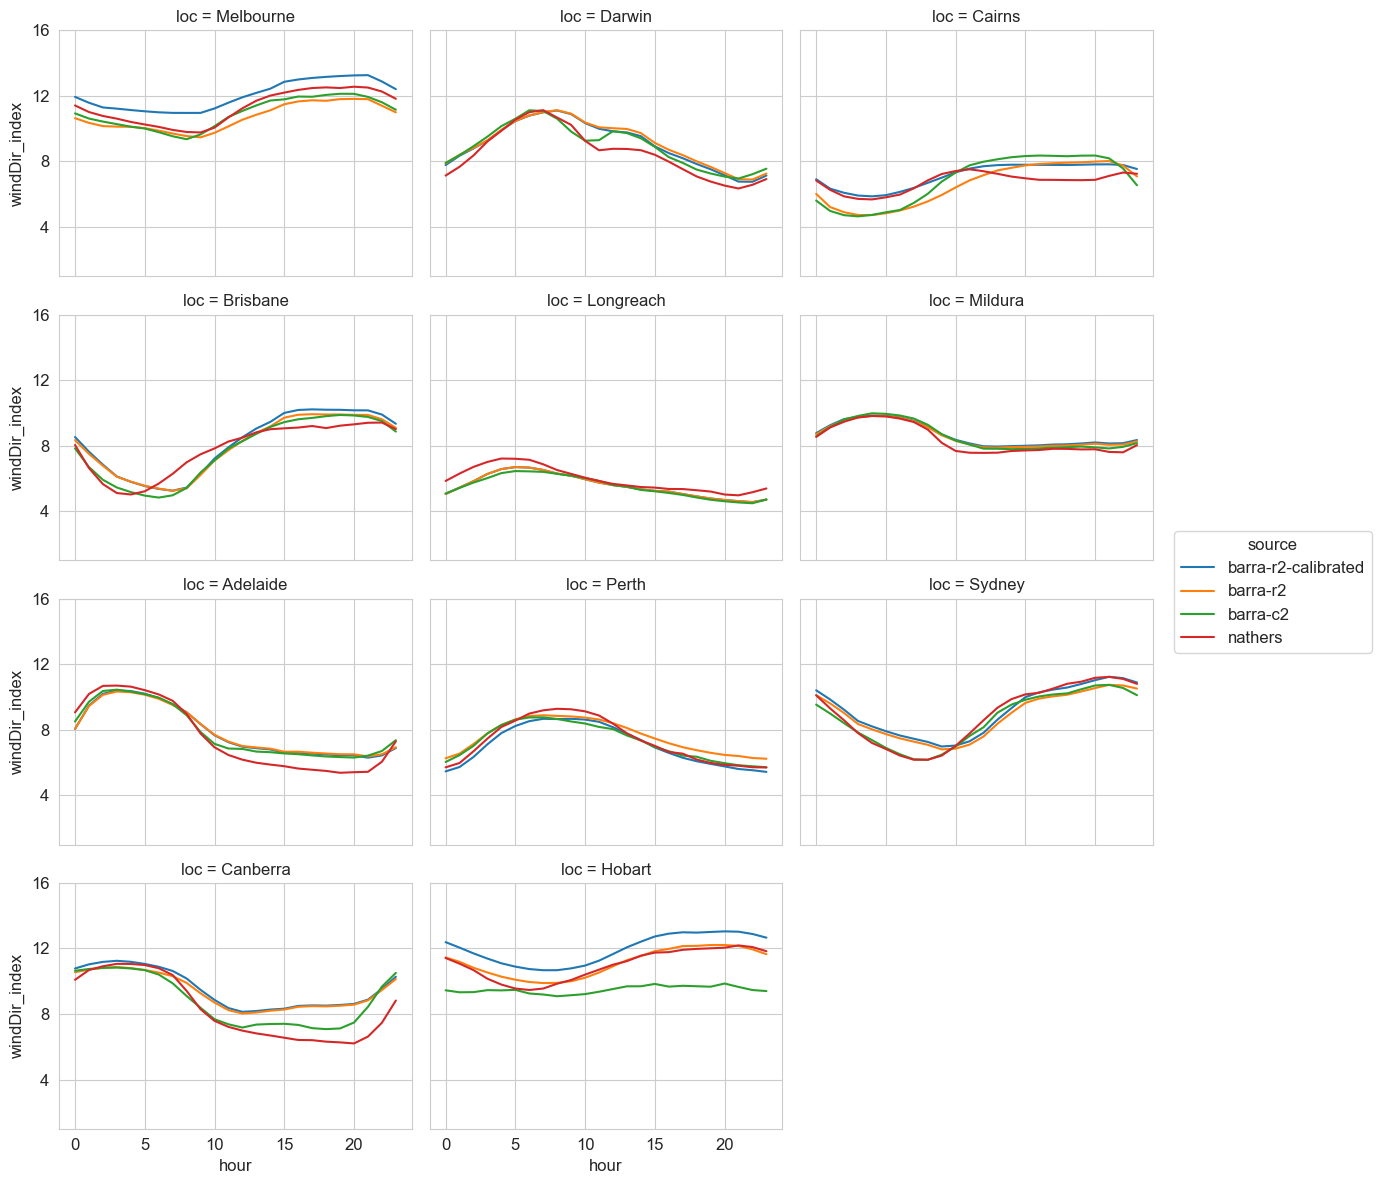

In [81]:
diurnal_circular_mean(all_new_idx).plot(   #all_wind_dir_deg.groupby("time.hour").mean("time").plot(
    hue="source",
    col="loc",
    col_wrap=3,
    ylim=(1,16),  
    yticks=[0,4,8,12,16],
    figsize=(12,12)
)

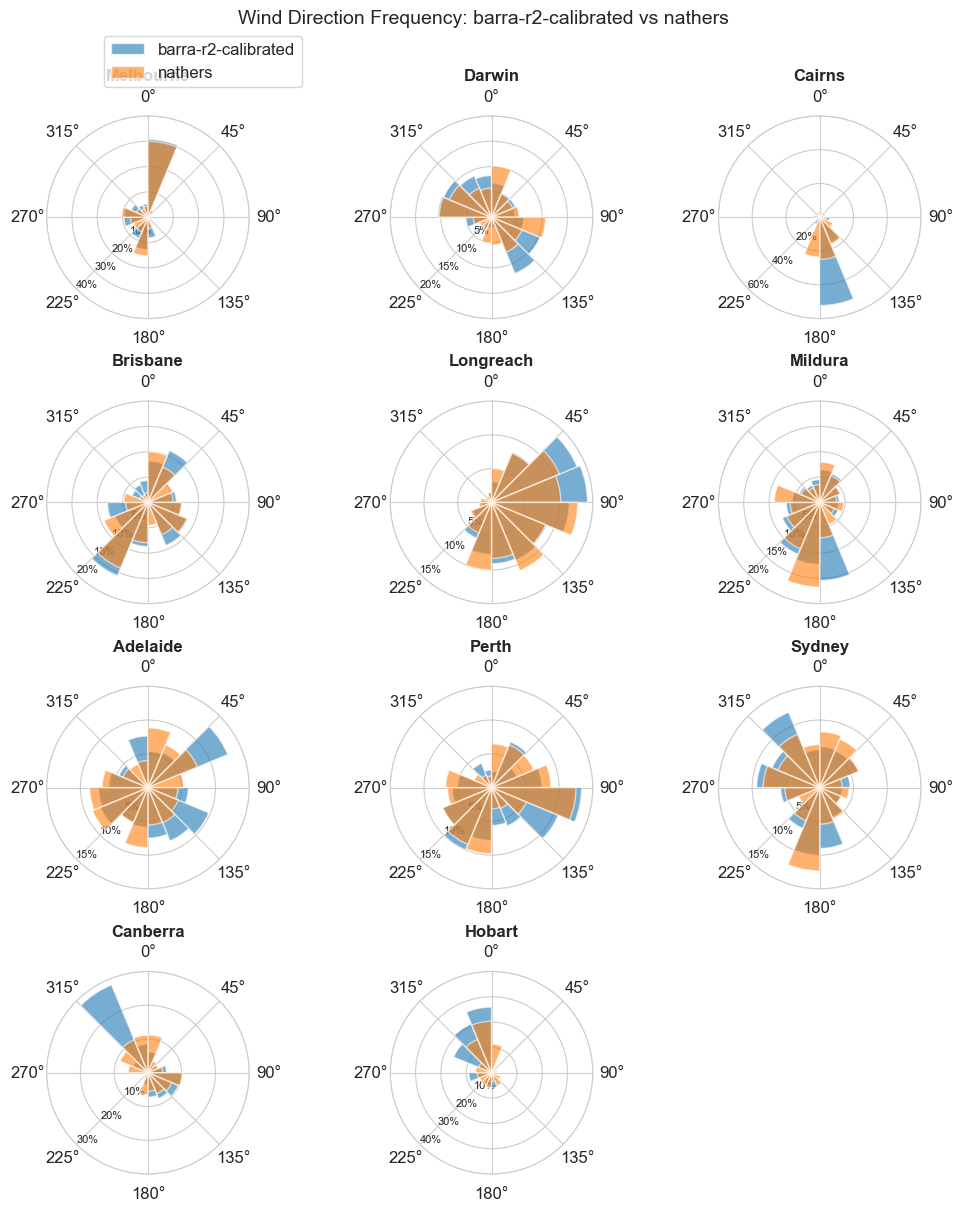

In [90]:
plot_windrose_overlay(
    da=dir16_to_deg(all_new_idx),
    model_source="barra-r2-calibrated",
    obs_source="nathers",
    n_dir_bins=16,
    direction_type="degrees"
)

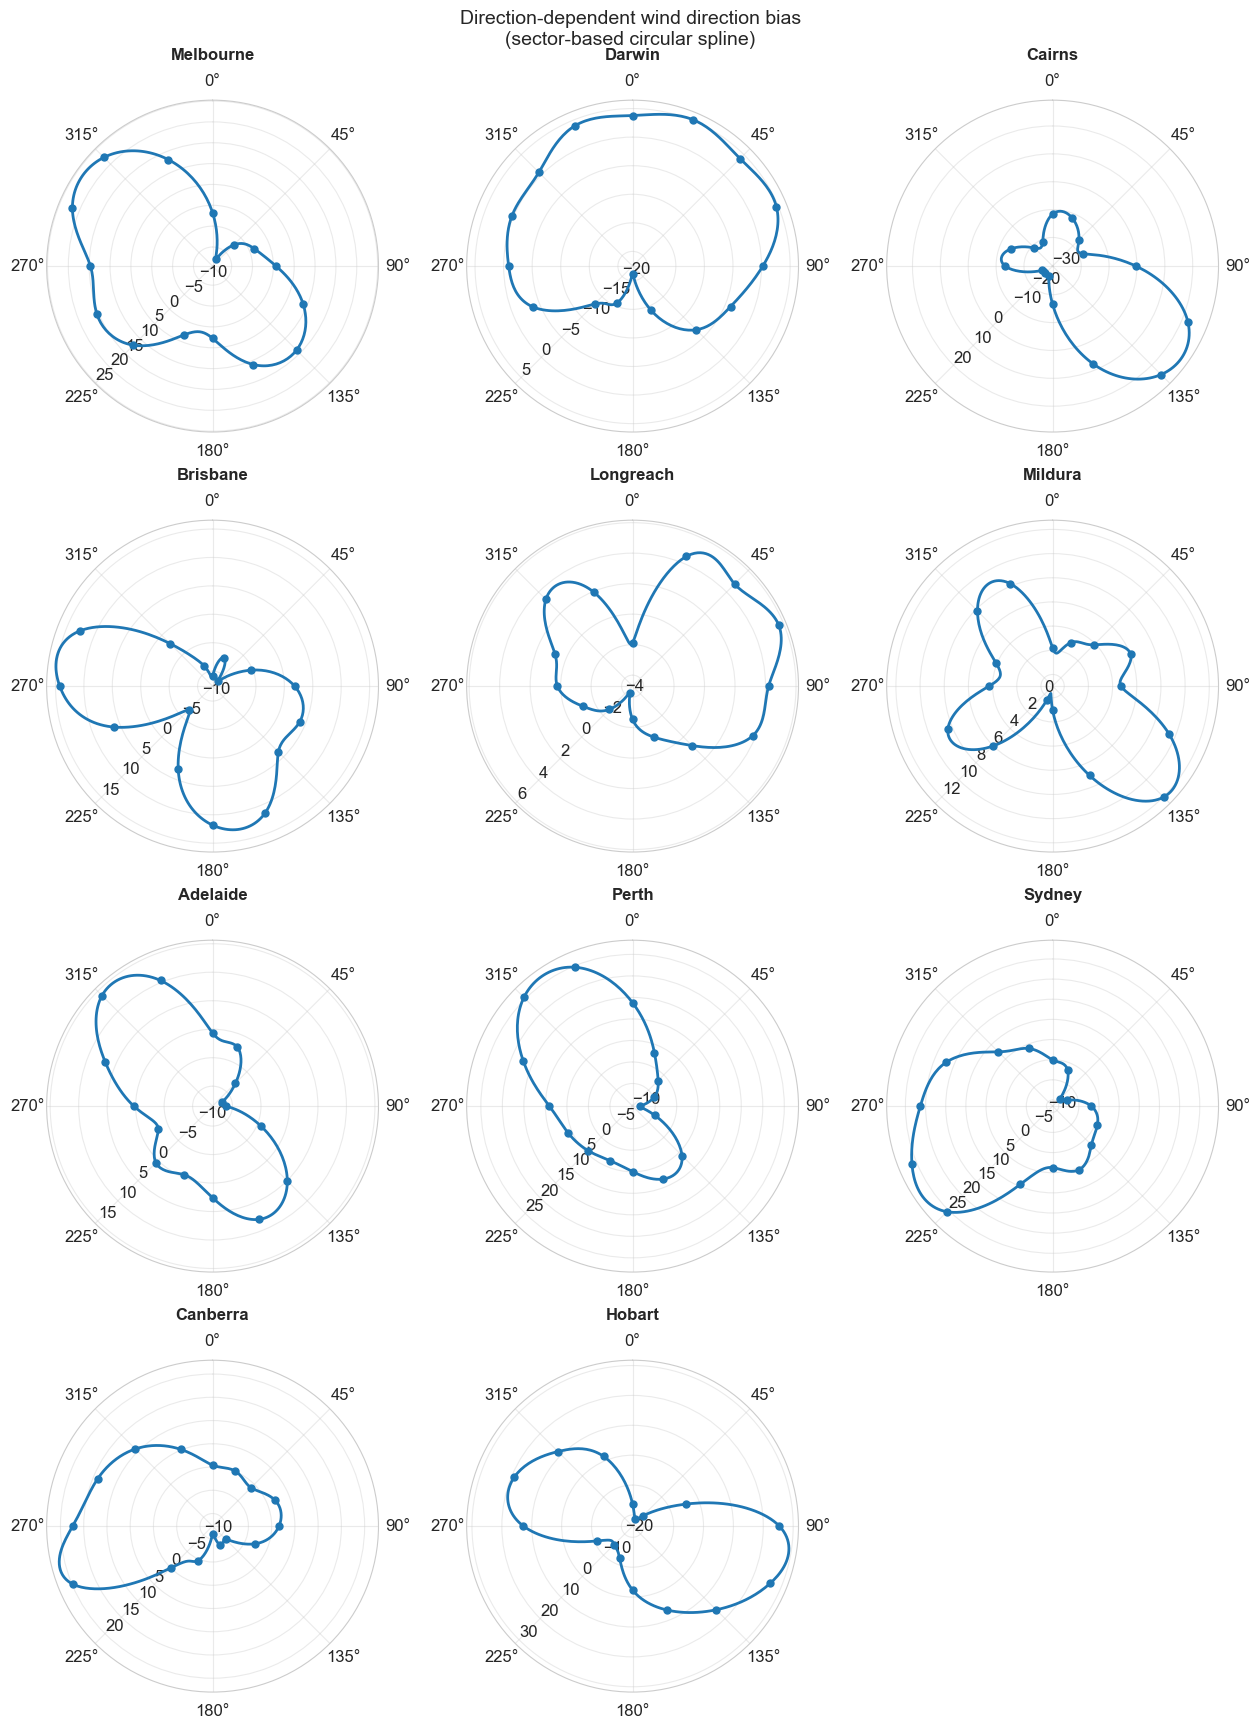

In [120]:
plot_bias(params_by_loc_idx)

### WITHOUT binning of BARRA wind direction
(i.e. continuous scale 0-360˚)

In [110]:
# =============================================================================
# Direction-dependent wind direction calibration
#
# This cell implements a wind-direction calibration adapted from
# Mínguez et al. (2011), originally developed for wave direction.
#
# Key principles:
# - Wind direction is a circular variable (0° ≡ 360°)
# - Wind speed is used ONLY to filter calm conditions since it's already adjusted using QDC
# - Directional bias is estimated by angular sector
# - A smooth periodic spline enforces continuity at North
# - Calibration is applied independently at each location
# =============================================================================

import numpy as np
import xarray as xr
from scipy.interpolate import CubicSpline
from scipy.stats import circmean

# -----------------------------------------------------------------------------
# Helper functions for circular calculations
# -----------------------------------------------------------------------------

def to_radians(deg):
    return np.deg2rad(deg)

def to_degrees(rad):
    return np.rad2deg(rad)

def circular_difference(obs_deg, mod_deg):
    """
    Smallest signed angular difference (obs - mod), degrees
    """
    diff = obs_deg - mod_deg
    return (diff + 180) % 360 - 180
    
def wrap_degrees(deg):
    # Wrap angles into [0, 360)
    return (deg + 360) % 360

# -----------------------------------------------------------------------------
# Configuration parameters (held fixed across all locations)
# -----------------------------------------------------------------------------

calm_threshold = 0.026        # m/s; used only to filter calm winds
sector_size_deg = 22.5       # directional sector size (16 sectors)
min_samples = 1000            # minimum samples per sector to estimate bias


# -----------------------------------------------------------------------------
# Storage for calibrated wind direction and fitted directional calibration parameters
# -----------------------------------------------------------------------------

adjusted_dir_by_loc_deg = {}
params_by_loc_deg = {}

# -----------------------------------------------------------------------------
# Loop over all locations
# -----------------------------------------------------------------------------

for loc in all_wind_spd["loc"].values:
    print("\n" + "=" * 90)
    print(f"Processing location: {loc}")
    print("=" * 90)

    # -------------------------------------------------------------------------
    # 1. Extract observed and modelled wind speed and direction
    # -------------------------------------------------------------------------

    # Observations
    speed_obs = all_wind_spd.sel(source="nathers", loc=loc)
    dir_obs   = all_wind_dir_deg.sel(source="nathers", loc=loc)
    
    # Model (raw direction)
    speed_mod = all_wind_spd.sel(source="barra-r2", loc=loc)
    dir_mod   = all_wind_dir_deg.sel(source="barra-r2", loc=loc)
    
    # Model (bias-adjusted wind speed from QDC)
    speed_mod_adj = all_wind_spd.sel(source="barra-r2-qdc", loc=loc)

    # -------------------------------------------------------------------------
    # 2. Filter calm wind conditions
    #
    # Wind direction is unreliable under calm conditions. Wind speed is NOT used
    # for quantile matching or correction of direction magnitude.
    # -------------------------------------------------------------------------

    valid = (
        (speed_obs > calm_threshold) &
        (speed_mod_adj > calm_threshold)
    )
    
    dir_obs_valid = dir_obs.where(valid, drop=True)
    dir_mod_valid = dir_mod.where(valid, drop=True)

    # If too few valid points remain, skip this location
    if dir_obs_valid.size < min_samples:
        print("  ⚠ insufficient valid data, skipping")
        continue

    # -------------------------------------------------------------------------
    # 3. Convert directions to radians for circular calculations
    # -------------------------------------------------------------------------
    
    theta_obs = to_radians(dir_obs_valid)
    theta_mod = to_radians(dir_mod_valid)

    # -------------------------------------------------------------------------
    # 4. Define directional sectors
    #
    # The full 360° circle is divided into fixed angular sectors, mirroring the
    # wave-direction calibration approach in Mínguez et al. (2011).
    # -------------------------------------------------------------------------

    n_sectors = int(360 / sector_size_deg)
    
    sector_edges_deg = np.linspace(0, 360, n_sectors + 1)
    sector_centers_deg = (sector_edges_deg[:-1] + sector_edges_deg[1:]) / 2
    
    sector_edges_rad   = to_radians(sector_edges_deg)
    sector_centers_rad = to_radians(sector_centers_deg)

    # -------------------------------------------------------------------------
    # 5. Estimate mean directional bias in each sector
    #
    # Bias is computed as the mean circular difference between observed and
    # modelled wind direction within each sector.
    # -------------------------------------------------------------------------

    sector_bias_deg = np.zeros(n_sectors)

    print(f"Total points: {len(dir_mod)}")
    print(f"Valid points after calm filtering: {valid.sum().item()}")
    print(f"NaNs in observed: {np.isnan(speed_obs).sum().item()}, NaNs in model: {np.isnan(speed_mod).sum().item()}")

    for i in range(n_sectors):
        mask = (
            (theta_mod >= sector_edges_rad[i]) &
            (theta_mod <  sector_edges_rad[i + 1])
        )
    
        print(f"Sector {i+1}: {mask.sum().item()} points")

        if mask.sum() > 10:  # minimum sample size
            diff = circular_difference(
                dir_obs_valid[mask].values,
                dir_mod_valid[mask].values
            )
            sector_bias_deg[i] = np.nanmean(diff)
        else:
            sector_bias_deg[i] = 0.0
   
        # Debugging: check for non-finite values
        if not np.all(np.isfinite(sector_bias_deg)):
            print("  ⚠ Non-finite sector_bias detected:")
            print(sector_bias_deg)
            # Replace any non-finite values with zero
            sector_bias_deg[~np.isfinite(sector_bias_deg)] = 0.0
            
    # -------------------------------------------------------------------------
    # 6. Fit a smooth periodic spline to the sector-wise bias
    #
    # The spline ensures a smooth, continuous correction function that wraps
    # seamlessly at 0°/360°.
    # -------------------------------------------------------------------------

    sector_bias_rad = to_radians(sector_bias_deg)
    
    # Duplicate first point for periodicity
    theta_knots = np.append(sector_centers_rad,
                             sector_centers_rad[0] + 2*np.pi)
    bias_knots  = np.append(sector_bias_rad,
                             sector_bias_rad[0])
    
    # Debug: print knots before spline
    print("  theta_knots:", np.round(to_degrees(theta_knots), 1))
    print("  bias_knots (deg):", np.round(to_degrees(bias_knots), 1))

    spline = CubicSpline(
        theta_knots,
        bias_knots,
        bc_type="periodic"
    )

    # -------------------------------------------------------------------------
    # Store fitted parameters for this location
    # -------------------------------------------------------------------------
    
    params_by_loc_deg[loc] = {
        "thetaj": sector_centers_rad,   # sector centres (radians)
        "bias_knots": sector_bias_rad,  # sector-wise bias (radians)
        "sector_size_deg": sector_size_deg,
        "n_sectors": n_sectors,
    }

    # -------------------------------------------------------------------------
    # 7. Apply directional calibration to the full model time series
    # -------------------------------------------------------------------------

    theta_mod_full = to_radians(dir_mod)
    
    bias_full = spline(theta_mod_full)
    
    theta_corr_rad = theta_mod_full + bias_full
    theta_corr_deg = (to_degrees(theta_corr_rad) + 360) % 360

    # Store calibrated direction as an xarray DataArray
    dir_mod_corrected = xr.DataArray(
        theta_corr_deg,
        coords=dir_mod.coords,
        dims=dir_mod.dims,
        name="wind_degrees"
    )

    dir_mod_corrected.attrs["long_name"] = "Bias-adjusted wind direction"
    dir_mod_corrected.attrs["method"] = "Sector-based circular spline (Hs-style)"

    # --- Quick diagnostics --- 
    print("Mean absolute direction error before:",
          np.abs(circular_difference(dir_obs_valid, dir_mod_valid)).mean().item())
    
    print("Mean absolute direction error after:",
          np.abs(circular_difference(
              dir_obs_valid,
              dir_mod_corrected.sel(time=dir_obs_valid.time)
          )).mean().item())


    print("  ✔ calibration complete")

    adjusted_dir_by_loc_deg[loc] = dir_mod_corrected

# -----------------------------------------------------------------------------
# 8. Combine calibrated wind direction across all locations
# -----------------------------------------------------------------------------

all_dir_calibrated_deg = xr.concat(
    adjusted_dir_by_loc_deg.values(),
    dim="loc"
).assign_coords(loc=list(adjusted_dir_by_loc_deg.keys()))
all_dir_calibrated_deg = all_dir_calibrated_deg.expand_dims(source=["barra-r2-calibrated"])

print("\nAll locations processed successfully.")




Processing location: Melbourne
Total points: 219146
Valid points after calm filtering: 200229
NaNs in observed: 3830, NaNs in model: 2
Sector 1: 30797 points
Sector 2: 3579 points
Sector 3: 1310 points
Sector 4: 1008 points
Sector 5: 1232 points
Sector 6: 2447 points
Sector 7: 7448 points
Sector 8: 19006 points
Sector 9: 23574 points
Sector 10: 16742 points
Sector 11: 20002 points
Sector 12: 16506 points
Sector 13: 12135 points
Sector 14: 9944 points
Sector 15: 11823 points
Sector 16: 21483 points
  theta_knots: [ 11.2  33.8  56.2  78.8 101.2 123.8 146.2 168.8 191.2 213.8 236.2 258.8
 281.2 303.8 326.2 348.8 371.2]
  bias_knots (deg): [-6.5 -5.8 -1.3  2.3  5.4 13.  11.4  6.7  2.4  8.5 14.  16.2 18.2 23.7
 18.1  5.3 -6.5]
Mean absolute direction error before: 24.965635724594424
Mean absolute direction error after: 22.216843138136543
  ✔ calibration complete

Processing location: Darwin
Total points: 219146
Valid points after calm filtering: 196401
NaNs in observed: 1460, NaNs in model:

In [83]:
all_dir_calibrated_deg

<xarray.DataArray 'wind_degrees' (source: 1, loc: 11, time: 219146)> Size: 19MB
array([[[237.98965828, 233.7996184 , 230.71276353, ..., 311.16503909,
                  nan,          nan],
        [         nan,  18.18901417,  25.02912671, ...,  27.75288332,
          36.85056342,          nan],
        [167.04929604, 168.5265117 , 168.45595531, ..., 120.90861653,
                  nan,          nan],
        ...,
        [ 24.42327054,  18.79965302,   0.67404508, ...,  19.63269846,
                  nan,          nan],
        [ 79.9059022 , 124.9016179 , 117.84661583, ...,  93.49972724,
                  nan,          nan],
        [326.03747859, 251.75700162, 231.46983858, ..., 318.40812423,
                  nan,          nan]]])
Coordinates:
  * source        (source) object 8B 'barra-r2-calibrated'
  * loc           (loc) <U9 396B 'Melbourne' 'Darwin' ... 'Canberra' 'Hobart'
  * time          (time) datetime64[ns] 2MB 1989-12-31T14:00:00 ... 2014-12-3...
    lat           (loc) float64 88B -37.67 -12.42 -16.87 ... -33.94 -35.3 -42.89
    lon           (loc) float64 88B 144.8 130.9 145.7 ... 151.2 149.2 147.3
    crs           int32 4B 0
    time_offset   (loc) float64 88B 10.0 9.5 10.0 10.0 ... 8.0 10.0 10.0 10.0
    round_method  (loc) object 88B nan 'floor' nan nan nan ... nan nan nan nan
Attributes:
    long_name:  Bias-adjusted wind direction
    method:     Sector-based circular spline (Hs-style)

In [84]:
all_new_deg = xr.concat([all_dir_calibrated_deg,all_wind_dir_deg],
                    dim='source').sel(time=slice("1995",None))
all_new_deg

<xarray.DataArray 'wind_degrees' (source: 4, loc: 11, time: 175312)> Size: 62MB
array([[[215.8073716 , 210.96985169, 188.99029876, ..., 311.16503909,
                  nan,          nan],
        [277.87177675, 263.54456174, 264.24416865, ...,  27.75288332,
          36.85056342,          nan],
        [124.2737207 ,  95.64291377,  77.06155289, ..., 120.90861653,
                  nan,          nan],
        ...,
        [  5.21817569,  11.00294983,  17.38634545, ...,  19.63269846,
                  nan,          nan],
        [313.94093612, 308.52676075, 303.97543977, ...,  93.49972724,
                  nan,          nan],
        [255.50918383, 261.70769552, 255.16530655, ..., 318.40812423,
                  nan,          nan]],

       [[208.96005669, 205.38790629, 186.4659321 , ..., 290.37643521,
                  nan,          nan],
        [276.07245641, 262.96205924, 263.57125225, ...,  22.16634582,
          32.00538321,          nan],
        [107.00285264,  92.43664825,  83.82007575, ..., 105.01836063,
                  nan,          nan],
...
        [ 17.10272897,  36.43085812,  47.53355889, ...,  26.11391263,
                  nan,          nan],
        [300.65066796, 301.60750225, 286.87626462, ..., 182.96579741,
                  nan,          nan],
        [244.72227776, 247.94893728, 244.76716868, ..., 341.56505118,
                  nan,          nan]],

       [[202.5       , 180.        , 180.        , ..., 270.        ,
                  nan,          nan],
        [292.5       , 292.5       , 292.5       , ...,  67.5       ,
          67.5       ,          nan],
        [         nan,  90.        , 112.5       , ..., 180.        ,
                  nan,          nan],
        ...,
        [ 22.5       ,  45.        ,  45.        , ..., 360.        ,
                  nan,          nan],
        [         nan, 315.        , 292.5       , ..., 135.        ,
                  nan,          nan],
        [270.        , 225.        , 247.5       , ..., 337.5       ,
                  nan,          nan]]])
Coordinates:
  * source        (source) object 32B 'barra-r2-calibrated' ... 'nathers'
  * loc           (loc) <U9 396B 'Melbourne' 'Darwin' ... 'Canberra' 'Hobart'
  * time          (time) datetime64[ns] 1MB 1995-01-01 ... 2014-12-31T15:00:00
    lat           (loc) float64 88B -37.67 -12.42 -16.87 ... -33.94 -35.3 -42.89
    lon           (loc) float64 88B 144.8 130.9 145.7 ... 151.2 149.2 147.3
    crs           int32 4B 0
    time_offset   (loc) float64 88B 10.0 9.5 10.0 10.0 ... 8.0 10.0 10.0 10.0
    round_method  (loc) object 88B nan 'floor' nan nan nan ... nan nan nan nan
Attributes:
    long_name:  Bias-adjusted wind direction
    method:     Sector-based circular spline (Hs-style)

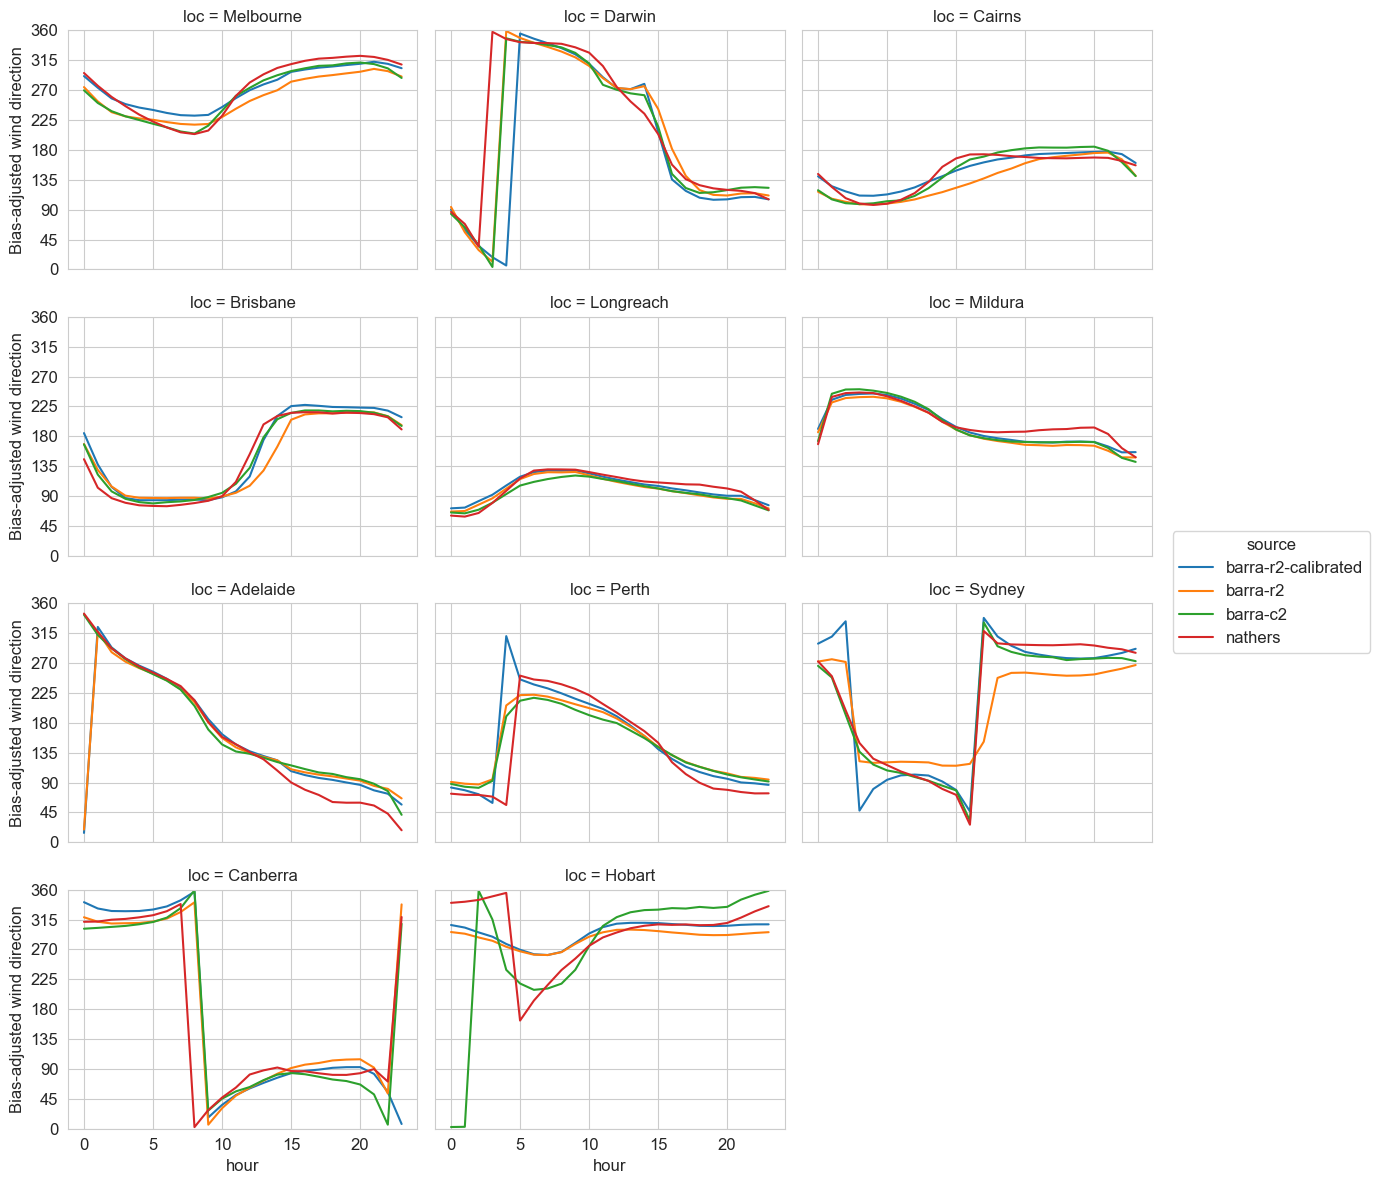

In [86]:
diurnal_circular_mean(all_new_deg).plot(   #all_wind_dir_deg.groupby("time.hour").mean("time").plot(
    hue="source",
    col="loc",
    col_wrap=3,
    ylim=(0, 360),  
    yticks=np.arange(0, 361, 45),
    figsize=(12,12)
)

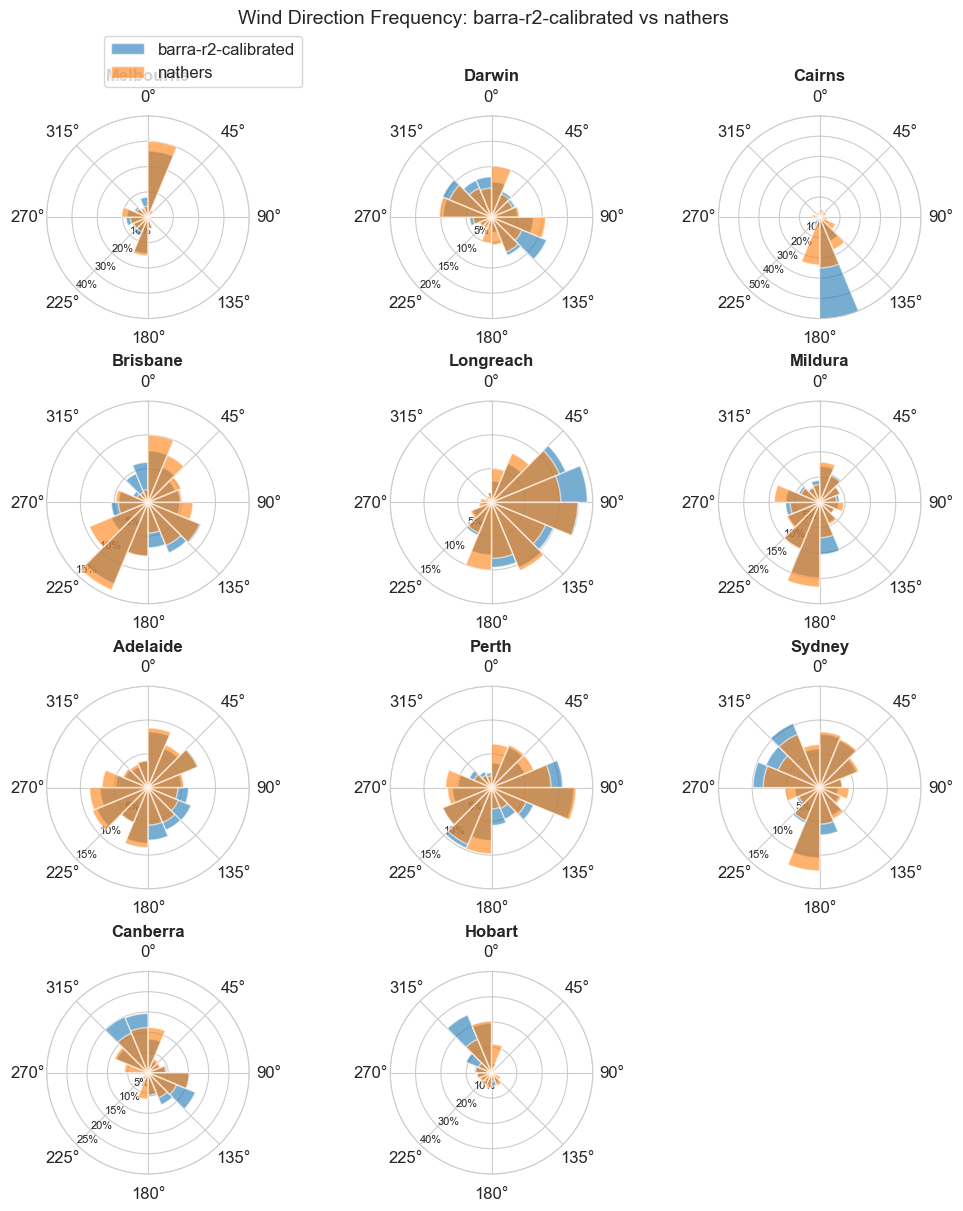

In [91]:
plot_windrose_overlay(
    da=all_new_deg,
    model_source="barra-r2-calibrated",
    obs_source="nathers",
    n_dir_bins=16,
    direction_type="degrees"
)

### Direction-dependent wind direction calibration
Wind direction is a circular variable, for which 0° and 360° are equivalent. As a result, direction errors are most appropriately represented as angular rotations rather than linear scaling. Following the sector-based approach of Mínguez et al. (2011), a direction-dependent bias function 
𝑏(𝜃) b(θ) is estimated, where 𝜃 θ denotes the modelled wind direction. The bias is computed as the mean circular difference between observed and modelled wind directions within fixed angular sectors, after filtering calm wind conditions using wind speed. A smooth periodic cubic spline is then fitted to the sector-wise bias estimates to ensure continuity across the full 0–360° range. The calibrated wind direction is obtained by adding the fitted bias function to the modelled direction, 𝜃 corr=𝜃mod+𝑏(𝜃mod). No multiplicative term 𝑎(𝜃) is applied, as scaling of angular quantities has no physical interpretation and would violate the circular nature of wind direction.

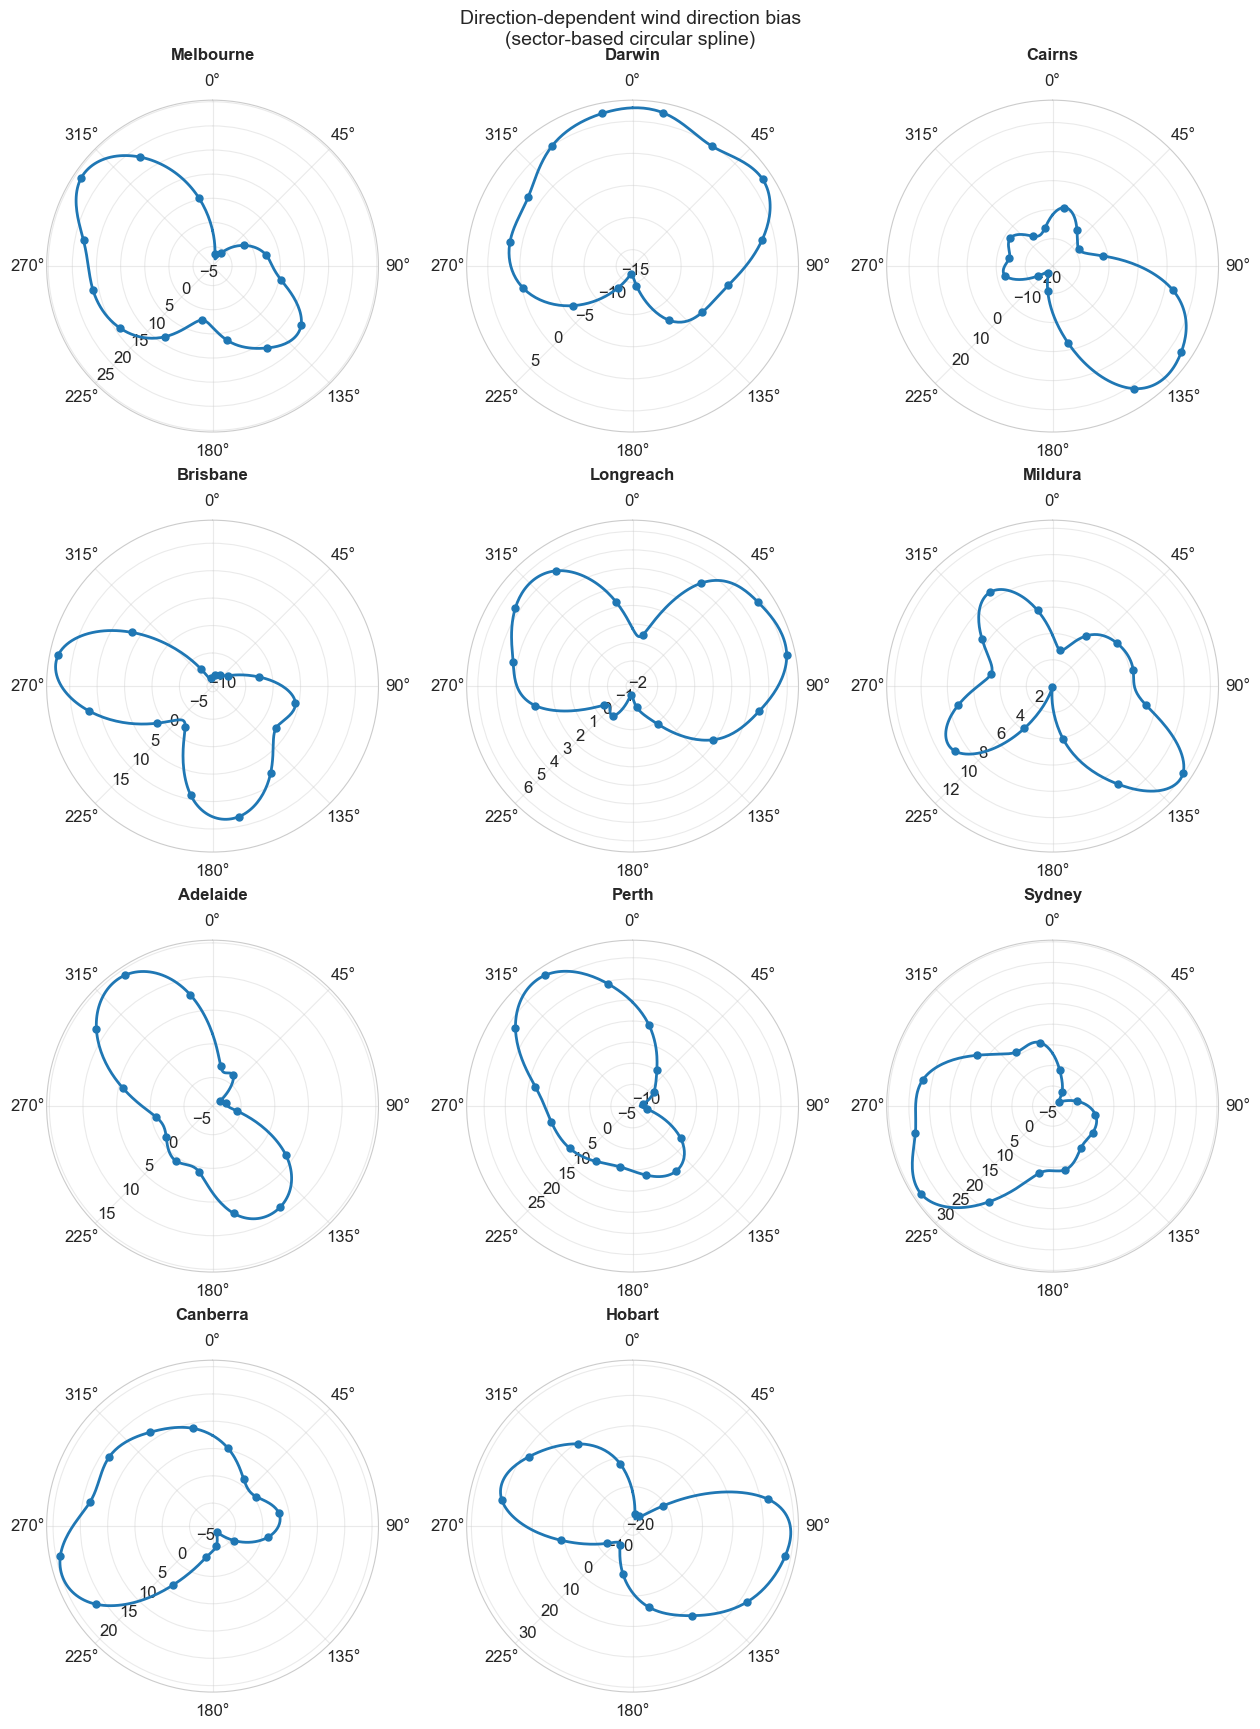

In [111]:
plot_bias(params_by_loc_deg)

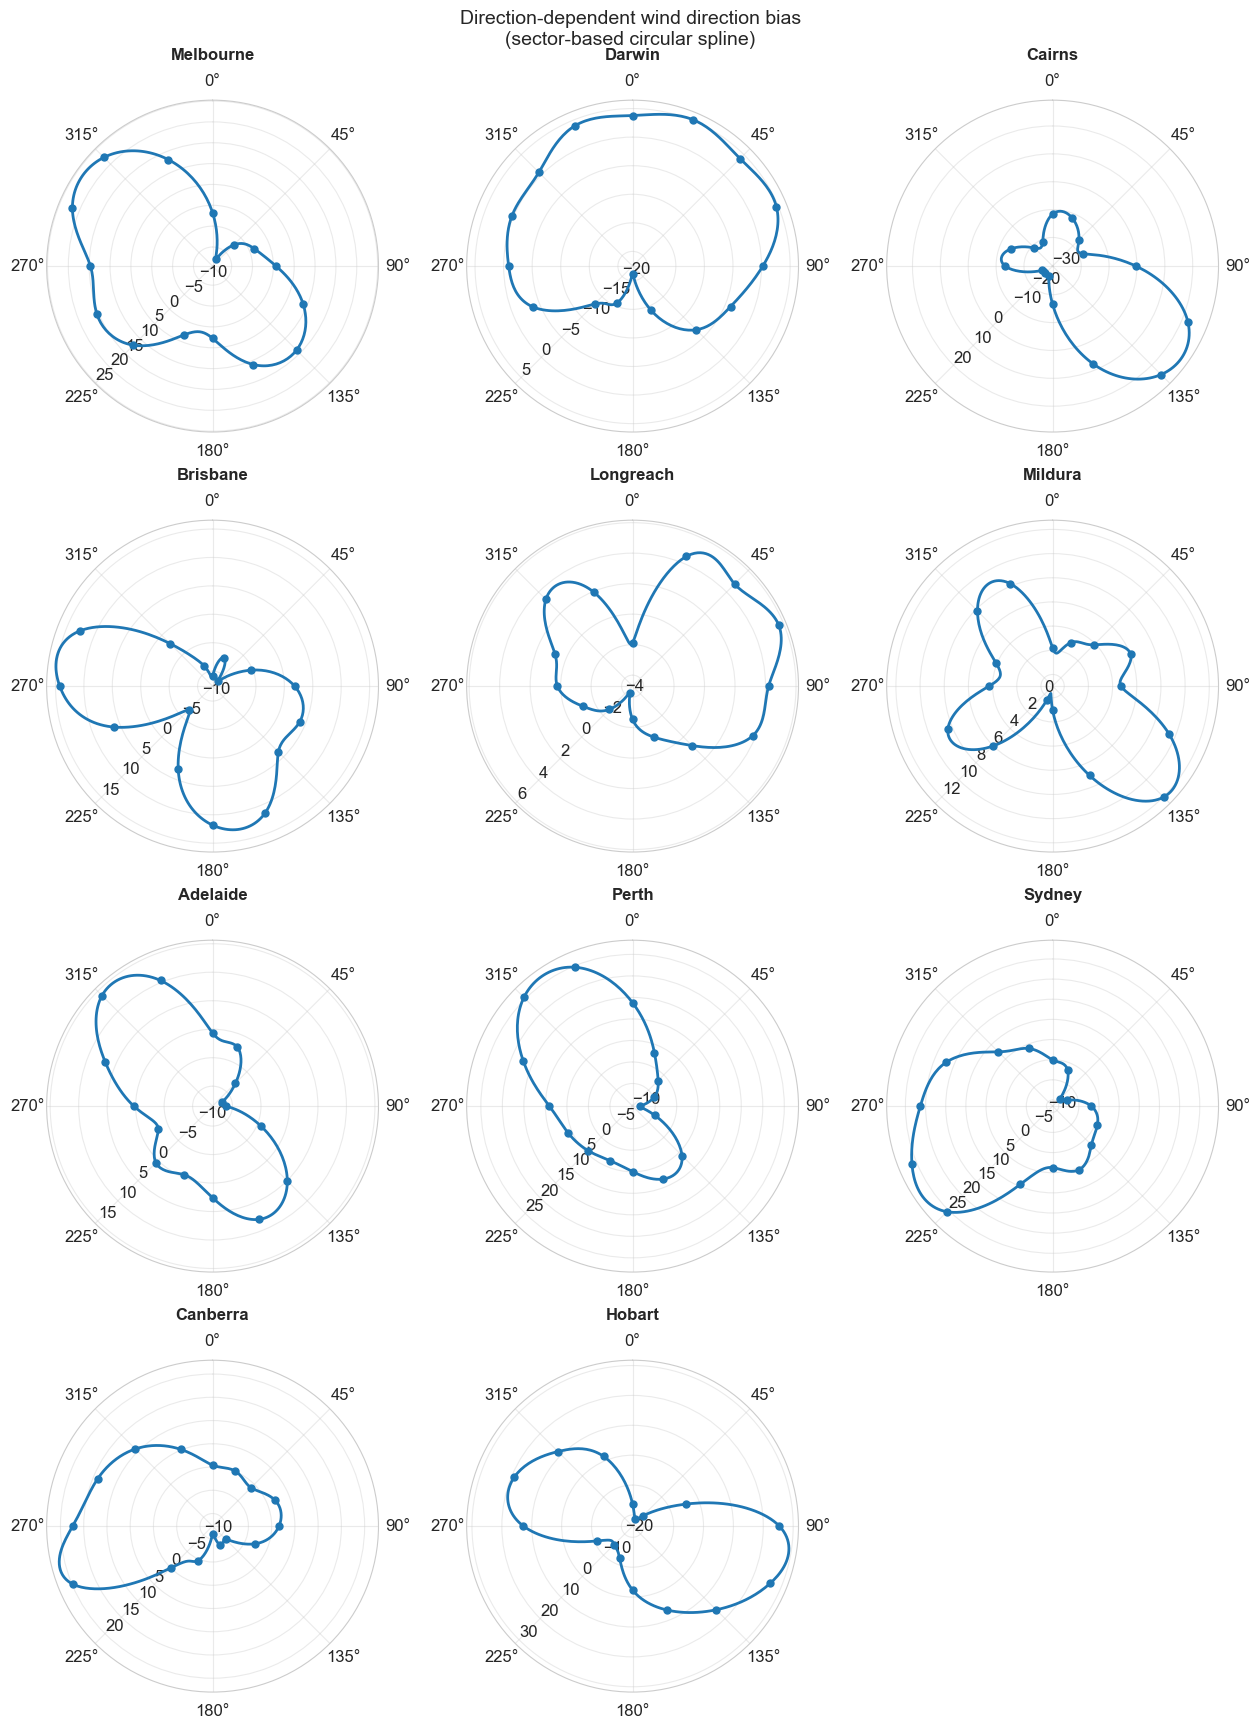

In [128]:
plot_bias(params_by_loc_idx)